In [1]:
"""
Production-Ready VAE-SAE Interpretability Collapse Implementation
Version: 8.0 - Complete with W&B Integration
Paper: "The Interpretability Paradox in Adaptive Sparse Autoencoders"
Experiment: Demonstrating k=500→50 phase transition with preserved disentanglement
"""
!pip install torch torchvision numpy wandb tqdm matplotlib seaborn scikit-learn scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, Tuple, Optional, List, Any
from dataclasses import dataclass, field
import pickle
import gzip
import urllib.request
import os
import time
from datetime import datetime
from tqdm import tqdm
import warnings
from collections import defaultdict
import pandas as pd
from scipy import stats
from scipy.stats import entropy, pointbiserialr, pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
warnings.filterwarnings('ignore')

# Check for W&B availability
try:
    import wandb
    HAS_WANDB = True
except ImportError:
    HAS_WANDB = False
    print("WARNING: W&B not installed. Install with: pip install wandb")

# ==================== Configuration ====================
@dataclass
class ExperimentConfig:
    """Complete configuration for interpretability collapse experiments"""

    # Core experimental parameters - THE HEART OF YOUR NOVELTY
    k_start: int = 500  # Starting sparsity level
    k_end: int = 50     # Ending sparsity level (90% reduction)
    schedule_type: str = "piecewise"  # Changed for better control
    schedule_warmup: int = 5
    schedule_cooldown: int = 5

    # Model architecture
    latent_dim: int = 10
    sae_hidden_multiplier: int = 2  # Reduced for stability

    # VAE settings - prevent posterior collapse
    beta_start: float = 0.1  # Very low initial beta
    beta_end: float = 1.0    # Moderate final beta
    free_bits: float = 5.0   # High free bits threshold
    kl_warmup_epochs: int = 10
    kl_annealing_type: str = "cosine"

    # Training epochs - will be overridden for quick test
    stage1_vae_epochs: int = 30
    stage2_sae_epochs: int = 10
    stage3_joint_epochs: int = 50

    # Optimization
    batch_size: int = 128
    learning_rate_vae: float = 1e-3
    learning_rate_sae: float = 5e-4
    learning_rate_joint: float = 1e-5
    gradient_clip: float = 1.0
    weight_decay: float = 1e-4
    gradient_accumulation_steps: int = 1

    # Model stability
    use_spectral_norm: bool = True
    encoder_dropout: float = 0.1
    use_mixed_precision: bool = True

    # Evaluation thresholds - CRITICAL FOR YOUR PAPER
    specialization_threshold_high: float = 0.3
    specialization_threshold_mid: float = 0.15
    n_samples_mig: int = 10000
    n_samples_specialization: int = 5000
    n_samples_causal: int = 1000
    eval_every_n_epochs: int = 2

    # Phase transition detection - KEY NOVELTY
    track_phase_transition: bool = True
    confidence_level: float = 0.95

    # Novel interventions
    use_interpretability_loss: bool = False
    interpretability_loss_weight: float = 0.1
    use_progressive_freezing: bool = False
    freeze_top_n_features: int = 50
    use_monosemanticity_reg: bool = False
    monosemanticity_weight: float = 0.01

    # W&B Configuration
    use_wandb: bool = True
    wandb_project: str = "vae-sae-interpretability-collapse"
    wandb_entity: Optional[str] = None  # Your W&B username/team
    wandb_tags: List[str] = field(default_factory=lambda: ["baseline", "k500-50"])
    wandb_notes: str = "Interpretability paradox experiment"
    save_checkpoints_to_wandb: bool = True
    log_frequency: int = 100  # Log every N batches

    # Checkpointing
    checkpoint_dir: str = "./checkpoints"
    save_every_n_epochs: int = 5
    keep_n_checkpoints: int = 3
    save_best_only: bool = False

    # Modes
    quick_test_mode: bool = False
    test_mode: bool = False
    debug_mode: bool = False

    # System
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers: int = 2
    pin_memory: bool = True
    results_dir: str = "./results"

    # Experiment tracking
    experiment_name: str = ""
    experiment_type: str = "interpretability_collapse"
    experiment_version: str = "8.0"
    current_seed: int = 141
    n_seeds: int = 1

    # Enhanced data collection
    collect_intermediate_checkpoints: bool = True
    checkpoint_k_targets: List[int] = field(
        default_factory=lambda: [500, 450, 400, 350, 300, 257, 250, 200, 150, 100, 75, 50]
    )
    min_epochs_per_k: int = 2  # Ensure we spend time at each k value

    def __post_init__(self):
        Path(self.results_dir).mkdir(parents=True, exist_ok=True)
        Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)

        # Generate experiment name
        mode_suffix = "_quicktest" if self.quick_test_mode else "_test" if self.test_mode else ""
        if not self.experiment_name:
            self.experiment_name = f"k{self.k_start}_{self.k_end}{mode_suffix}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

    def to_dict(self):
        """Convert config to dictionary for saving"""
        config_dict = {}
        for key, value in self.__dict__.items():
            if isinstance(value, np.integer):
                config_dict[key] = int(value)
            elif isinstance(value, np.floating):
                config_dict[key] = float(value)
            elif isinstance(value, np.ndarray):
                config_dict[key] = value.tolist()
            else:
                config_dict[key] = value
        return config_dict

    @property
    def total_epochs(self):
        return self.stage1_vae_epochs + self.stage2_sae_epochs + self.stage3_joint_epochs

def create_quick_test_config():
    """Factory function for quick test configuration"""
    config = ExperimentConfig()
    config.quick_test_mode = True
    config.stage1_vae_epochs = 5
    config.stage2_sae_epochs = 2
    config.stage3_joint_epochs = 5
    config.eval_every_n_epochs = 1
    config.n_samples_mig = 2000
    config.n_samples_specialization = 1000
    config.num_workers = 0
    config.pin_memory = False
    config.use_wandb = False  # Disable W&B for quick test
    return config

def create_test_config():
    """Factory function for test configuration"""
    config = ExperimentConfig()
    config.test_mode = True
    config.stage1_vae_epochs = 30
    config.stage2_sae_epochs = 10
    config.stage3_joint_epochs = 50
    config.eval_every_n_epochs = 3
    config.schedule_warmup = 5       # Reduce from 5
    config.schedule_cooldown = 5     # Reduce from 5
    config.n_samples_mig = 5000
    config.n_samples_specialization = 2500
    config.learning_rate_joint = 1e-5  # Reduced from default 1e-4
    config.num_workers = 16  # Increase from default 2
    config.batch_size = 256  # Increase from default 128 (optional - test first)
    config.pin_memory = True  # Should already be True
    return config

# ==================== Utility Functions ====================
def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def download_dsprites():
    dataset_path = './dsprites.npz'
    if not os.path.exists(dataset_path):
        print("Downloading dSprites dataset...")
        url = 'https://github.com/deepmind/dsprites-dataset/raw/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'

        def download_progress(block_num, block_size, total_size):
            downloaded = block_num * block_size
            percent = min(100, downloaded * 100 / total_size)
            print(f"Download progress: {percent:.1f}%", end='\r')

        try:
            urllib.request.urlretrieve(url, dataset_path, reporthook=download_progress)
            print("\nDownload complete!")
        except Exception as e:
            print(f"Error downloading dataset: {e}")
            raise
    return dataset_path

# ==================== W&B Functions ====================
def init_wandb(config: ExperimentConfig):
    """Initialize W&B with comprehensive tracking"""
    if not config.use_wandb or not HAS_WANDB:
        return None

    print("Initializing W&B...")

    run = wandb.init(
        project=config.wandb_project,
        entity=config.wandb_entity,
        config=config.to_dict(),
        name=config.experiment_name,
        tags=config.wandb_tags,
        notes=config.wandb_notes,
        save_code=True,
        reinit=True
    )

    # Define custom metrics for interpretability tracking
    wandb.define_metric("epoch")
    wandb.define_metric("k_value")
    wandb.define_metric("global_step")
    wandb.define_metric("train/*", step_metric="epoch")
    wandb.define_metric("val/*", step_metric="epoch")
    wandb.define_metric("interpretability/*", step_metric="epoch")
    wandb.define_metric("phase_transition/*", step_metric="epoch")

    return run

def save_checkpoint(model, optimizer, epoch, stage, metrics, config, wandb_run=None):
    """Save checkpoint locally and to W&B"""
    checkpoint = {
        'epoch': epoch,
        'stage': stage,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
        'metrics': metrics,
        'config': config.to_dict(),
        'timestamp': datetime.now().isoformat()
    }

    # Save locally
    checkpoint_path = Path(config.checkpoint_dir) / f"{config.experiment_name}_stage{stage}_epoch{epoch}.pt"
    torch.save(checkpoint, checkpoint_path)

    # Save to W&B
    if wandb_run and config.save_checkpoints_to_wandb:
        artifact = wandb.Artifact(
            name=f"model-{config.experiment_name}",
            type="model",
            description=f"Stage: {stage}, Epoch: {epoch}",
            metadata=metrics
        )
        artifact.add_file(checkpoint_path)
        wandb_run.log_artifact(artifact)

        # Also save as W&B model for easy access
        wandb_run.save(str(checkpoint_path))

    return checkpoint_path

def plot_interpretability_collapse(phase_transition_data):
    """Create publication-quality plot for W&B"""
    fig, ax = plt.subplots(figsize=(10, 6))

    k_vals = phase_transition_data['k_values']
    specialized = phase_transition_data['specialized']

    ax.scatter(k_vals, specialized, s=100, alpha=0.7, c='red', edgecolors='black')
    ax.plot(k_vals, specialized, 'r--', alpha=0.5)

    ax.set_xlabel('k (Number of Active Neurons)', fontsize=12)
    ax.set_ylabel('Number of Specialized Neurons', fontsize=12)
    ax.set_title('Interpretability Collapse as k Decreases', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Mark phase transition if detected
    if 'breakpoint' in phase_transition_data and phase_transition_data['breakpoint']:
        ax.axvline(x=phase_transition_data['breakpoint'], color='blue',
                  linestyle=':', linewidth=2, label=f"Phase Transition (k={phase_transition_data['breakpoint']})")
        ax.legend()

    plt.tight_layout()
    return fig

# ==================== Dataset ====================
class DSpritesDataset(Dataset):
    def __init__(self, path: str, split: str = 'train', test_mode: bool = False):
        data = np.load(path, allow_pickle=True)
        self.images = data['imgs'].astype(np.float32)
        self.factors = data['latents_values'].astype(np.float32)

        # Normalize factors for correlation computation
        for i in range(1, self.factors.shape[1]):
            self.factors[:, i] = (self.factors[:, i] - self.factors[:, i].min()) / \
                                 (self.factors[:, i].max() - self.factors[:, i].min() + 1e-8)

        # Deterministic split
        np.random.seed(42)
        n_samples = len(self.images)
        indices = np.random.permutation(n_samples)

        if split == 'train':
            indices = indices[:int(0.8 * n_samples)]
        elif split == 'val':
            indices = indices[int(0.8 * n_samples):int(0.9 * n_samples)]
        else:
            indices = indices[int(0.9 * n_samples):]

        self.images = self.images[indices]
        self.factors = self.factors[indices]

        print(f"{split.upper()} dataset: {len(self.images)} samples")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.FloatTensor(self.images[idx]).unsqueeze(0)
        factors = torch.FloatTensor(self.factors[idx])
        return img, factors

# ==================== Model Components ====================
class StableBatchNorm2d(nn.Module):
    """Numerically stable batch normalization"""
    def __init__(self, num_features):
        super().__init__()
        self.bn = nn.BatchNorm2d(num_features, eps=1e-5, momentum=0.1)

    def forward(self, x):
        if x.shape[0] == 1:
            return x
        return self.bn(x)

class VAEEncoder(nn.Module):
    """Stable VAE encoder with proper normalization"""

    def __init__(self, config):
        super().__init__()
        self.config = config

        conv_layer = nn.Conv2d
        if config.use_spectral_norm:
            conv_layer = lambda *args, **kwargs: nn.utils.spectral_norm(nn.Conv2d(*args, **kwargs))

        self.conv_layers = nn.Sequential(
            conv_layer(1, 32, 4, 2, 1),
            StableBatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(config.encoder_dropout),

            conv_layer(32, 64, 4, 2, 1),
            StableBatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(config.encoder_dropout),

            conv_layer(64, 128, 4, 2, 1),
            StableBatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(config.encoder_dropout),

            conv_layer(128, 256, 4, 2, 1),
            StableBatchNorm2d(256),
            nn.ReLU(),
        )

        self.flatten_size = 256 * 4 * 4

        # Feature normalization layer
        self.feature_norm = nn.LayerNorm(self.flatten_size)

        # VAE latent projections
        self.fc_mu = nn.Linear(self.flatten_size, config.latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, config.latent_dim)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        h = self.conv_layers(x)
        h = h.view(h.size(0), -1)

        # Normalize features for SAE
        h_norm = self.feature_norm(h)

        # Project to latent space
        mu = self.fc_mu(h_norm)
        logvar = self.fc_logvar(h_norm)
        logvar = torch.clamp(logvar, min=-10, max=2)

        # Return normalized features for SAE
        return mu, logvar, h_norm * 1.0  # Scale down for SAE stability

class VAEDecoder(nn.Module):
    """VAE decoder"""

    def __init__(self, config):
        super().__init__()
        self.config = config

        deconv_layer = nn.ConvTranspose2d
        if config.use_spectral_norm:
            deconv_layer = lambda *args, **kwargs: nn.utils.spectral_norm(nn.ConvTranspose2d(*args, **kwargs))

        self.fc = nn.Linear(config.latent_dim, 256 * 4 * 4)

        self.deconv_layers = nn.Sequential(
            deconv_layer(256, 128, 4, 2, 1),
            StableBatchNorm2d(128),
            nn.ReLU(),

            deconv_layer(128, 64, 4, 2, 1),
            StableBatchNorm2d(64),
            nn.ReLU(),

            deconv_layer(64, 32, 4, 2, 1),
            StableBatchNorm2d(32),
            nn.ReLU(),

            deconv_layer(32, 1, 4, 2, 1),
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.ConvTranspose2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, z):
        h = self.fc(z)
        h = h.view(h.size(0), 256, 4, 4)
        return self.deconv_layers(h)

class StableSparseAutoencoder(nn.Module):
    """Simplified SAE with stable top-k sparsity"""

    def __init__(self, input_dim: int, hidden_multiplier: int = 2):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = input_dim * hidden_multiplier

        # Encoder and decoder
        self.encoder = nn.Linear(input_dim, self.hidden_dim, bias=True)
        self.decoder = nn.Linear(self.hidden_dim, input_dim, bias=False)

        # Initialize conservatively
        nn.init.kaiming_uniform_(self.encoder.weight, a=0.01)
        nn.init.constant_(self.encoder.bias, 0.01)
        nn.init.kaiming_uniform_(self.decoder.weight, a=0.01)

        # Tracking
        self.register_buffer('activation_counts', torch.zeros(self.hidden_dim))
        self.register_buffer('update_count', torch.tensor(0))
        self.register_buffer('dead_neuron_mask', torch.zeros(self.hidden_dim, dtype=torch.bool))

        self.frozen_neurons = set()

    def forward(self, x, k: int, training: bool = True):
        # Encode with ReLU
        hidden = F.relu(self.encoder(x))



        # Add tiny noise during training to break ties
        if training:
            hidden = hidden + torch.randn_like(hidden) * 1e-7

        # Apply top-k sparsity
        if k < self.hidden_dim:
            topk_vals, topk_indices = torch.topk(hidden, k, dim=-1)
            sparse_hidden = torch.zeros_like(hidden)
            sparse_hidden.scatter_(-1, topk_indices, topk_vals)
        else:
            sparse_hidden = hidden

        # Track activations
        if training:
            batch_active = (sparse_hidden > 0).float().mean(dim=0)
            self.activation_counts = 0.99 * self.activation_counts + 0.01 * batch_active
            self.update_count += 1

            # Update dead neuron mask
            if self.update_count > 100:
                self.dead_neuron_mask = self.activation_counts < 1e-5

        # Decode
        reconstructed = self.decoder(sparse_hidden)

        return reconstructed, sparse_hidden, hidden

    def get_statistics(self):
        """Get comprehensive statistics"""
        return {
            'dead_neurons': self.dead_neuron_mask.sum().item() if self.update_count > 100 else 0,
            'mean_activation': self.activation_counts.mean().item(),
            'std_activation': self.activation_counts.std().item(),
            'frozen_neurons': len(self.frozen_neurons),
            'total_neurons': self.hidden_dim,
            'activation_histogram': self.activation_counts.cpu().numpy()
        }

class HybridVAESAE(nn.Module):
    """Complete hybrid model - THE CORE OF YOUR CONTRIBUTION"""

    def __init__(self, config: ExperimentConfig):
        super().__init__()
        self.config = config

        # VAE components
        self.vae_encoder = VAEEncoder(config)
        self.vae_decoder = VAEDecoder(config)

        # SAE components - KEY INNOVATION
        self.conv_sae = StableSparseAutoencoder(
            self.vae_encoder.flatten_size,
            config.sae_hidden_multiplier
        )

        self.latent_sae = StableSparseAutoencoder(
            config.latent_dim,
            config.sae_hidden_multiplier
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, k_conv: int, k_latent: int, training: bool = True):
        # VAE encoding
        mu, logvar, conv_features = self.vae_encoder(x)
        z = self.reparameterize(mu, logvar)

        # SAE processing - YOUR KEY CONTRIBUTION
        conv_recon, conv_sparse, conv_hidden = self.conv_sae(conv_features, k_conv, training)
        z_recon, z_sparse, z_hidden = self.latent_sae(z, k_latent, training)

        # VAE decoding
        x_recon_logits = self.vae_decoder(z)
        x_recon = torch.sigmoid(x_recon_logits)

        return {
            'x_recon': x_recon,
            'x_recon_logits': x_recon_logits,
            'mu': mu,
            'logvar': logvar,
            'z': z,
            'conv_features': conv_features,
            'conv_recon': conv_recon,
            'conv_sparse': conv_sparse,
            'conv_hidden': conv_hidden,
            'z_recon': z_recon,
            'z_sparse': z_sparse,
            'z_hidden': z_hidden
        }

# ==================== Loss Functions ====================
def compute_vae_loss(outputs, target, config, epoch, stage='vae'):
    """VAE loss with free bits and KL annealing"""

    # Reconstruction loss
    if 'x_recon_logits' in outputs:
        recon_loss = F.binary_cross_entropy_with_logits(
            outputs['x_recon_logits'], target, reduction='mean'
        )
    else:
        recon_loss = F.binary_cross_entropy(outputs['x_recon'], target, reduction='mean')

    # KL divergence with free bits
    kl_per_dim = -0.5 * (1 + outputs['logvar'] - outputs['mu'].pow(2) - outputs['logvar'].exp())
    free_bits_per_dim = config.free_bits / config.latent_dim
    kl_per_dim = torch.maximum(kl_per_dim, torch.tensor(free_bits_per_dim).to(target.device))
    kl_loss = kl_per_dim.sum(dim=1).mean()

    # KL annealing
    if stage == 'vae':
        progress = min(1.0, epoch / config.kl_warmup_epochs)
        if config.kl_annealing_type == 'cosine':
            kl_weight = 0.5 * (1 - np.cos(np.pi * progress))
        else:
            kl_weight = progress

        # Beta scheduling
        beta = config.beta_start + (config.beta_end - config.beta_start) * \
               min(1.0, epoch / config.stage1_vae_epochs)
    else:
        kl_weight = 1.0
        beta = config.beta_end

    total_loss = recon_loss + kl_weight * beta * kl_loss

    return total_loss, {
        'total_loss': total_loss.item(),
        'recon_loss': recon_loss.item(),
        'kl_loss': kl_loss.item(),
        'kl_weight': kl_weight,
        'beta': beta
    }

def compute_joint_loss(outputs, target, factors, config, epoch):
    """Joint training loss with optional interventions"""

    # VAE loss
    vae_loss, vae_components = compute_vae_loss(outputs, target, config, epoch, 'joint')

    # SAE reconstruction losses
    sae_conv_loss = F.mse_loss(outputs['conv_recon'], outputs['conv_features'].detach())
    sae_z_loss = F.mse_loss(outputs['z_recon'], outputs['z'].detach())

    # Sparsity penalty
    sparse_conv = outputs['conv_sparse'].abs().mean()
    sparse_z = outputs['z_sparse'].abs().mean()

    # Combine losses
    total_loss = vae_loss + 0.1 * (sae_conv_loss + sae_z_loss) + \
                 1e-4 * (sparse_conv + sparse_z)

    loss_components = vae_components.copy()
    loss_components.update({
        'sae_conv_loss': sae_conv_loss.item(),
        'sae_z_loss': sae_z_loss.item(),
        'sparse_conv': sparse_conv.item(),
        'sparse_z': sparse_z.item()
    })

    # Optional interventions
    if config.use_interpretability_loss and factors is not None:
        interp_loss = compute_interpretability_loss(outputs['conv_sparse'], factors)
        total_loss += config.interpretability_loss_weight * interp_loss
        loss_components['interp_loss'] = interp_loss.item()

    if config.use_monosemanticity_reg:
        mono_loss = compute_monosemanticity_loss(outputs['conv_sparse'])
        total_loss += config.monosemanticity_weight * mono_loss
        loss_components['mono_loss'] = mono_loss.item()

    loss_components['total_loss'] = total_loss.item()

    return total_loss, loss_components

def compute_interpretability_loss(sparse_activations, factors):
    """Penalize polysemantic neurons"""
    n_neurons = min(100, sparse_activations.shape[1])
    n_factors = factors.shape[1]

    sparse_act_sample = sparse_activations[:, :n_neurons]

    correlations = []
    for j in range(n_factors):
        factor_expanded = factors[:, j].unsqueeze(1).expand(-1, n_neurons)
        corr = F.cosine_similarity(sparse_act_sample, factor_expanded, dim=0)
        correlations.append(corr.abs())

    corr_matrix = torch.stack(correlations, dim=1)

    # Encourage specialization (low entropy)
    probs = F.softmax(corr_matrix * 5.0, dim=1)
    entropy_val = -(probs * torch.log(probs + 1e-10)).sum(dim=1)

    return entropy_val.mean()

def compute_monosemanticity_loss(sparse_activations):
    """Encourage neurons to be consistently on or off"""
    activation_probs = (sparse_activations > 0).float().mean(dim=0)
    target_probs = 0.1
    penalty = (activation_probs - target_probs).pow(2)
    return penalty.mean()

# ==================== Evaluation Metrics ====================
def check_posterior_collapse(model, dataloader, device):
    """Check for posterior collapse"""
    model.eval()
    all_mu = []
    all_logvar = []

    with torch.no_grad():
        for i, (imgs, _) in enumerate(dataloader):
            if i >= 5:
                break
            imgs = imgs.to(device)
            mu, logvar, _ = model.vae_encoder(imgs)
            all_mu.append(mu)
            all_logvar.append(logvar)

    all_mu = torch.cat(all_mu, dim=0)
    all_logvar = torch.cat(all_logvar, dim=0)

    mu_var = all_mu.var(dim=0).mean().item()
    mu_mean = all_mu.mean().item()
    mu_std = all_mu.std().item()

    var_per_dim = all_mu.var(dim=0)
    collapsed_dims = (var_per_dim < 0.01).sum().item()

    kl = -0.5 * torch.sum(1 + all_logvar - all_mu.pow(2) - all_logvar.exp(), dim=1).mean().item()

    is_collapsed = mu_var < 0.01 or kl < 0.1 or collapsed_dims > 5

    return {
        'mu_variance': mu_var,
        'mu_mean': mu_mean,
        'mu_std': mu_std,
        'kl_divergence': kl,
        'collapsed_dims': collapsed_dims,
        'is_collapsed': is_collapsed
    }

def compute_mig_score(model, dataloader, device, n_samples=10000):
    """Compute MIG score for disentanglement"""
    model.eval()
    all_z, all_factors = [], []

    with torch.no_grad():
        for imgs, factors in dataloader:
            if len(all_z) * imgs.shape[0] >= n_samples:
                break
            imgs = imgs.to(device)
            mu, _, _ = model.vae_encoder(imgs)
            all_z.append(mu.cpu().numpy())
            all_factors.append(factors.cpu().numpy())

    if len(all_z) == 0:
        return 0.0, None

    all_z = np.concatenate(all_z)[:n_samples]
    all_factors = np.concatenate(all_factors)[:n_samples]

    # Normalize latents
    all_z = (all_z - all_z.mean(axis=0)) / (all_z.std(axis=0) + 1e-8)

    # Compute MI matrix
    n_latents, n_factors = all_z.shape[1], all_factors.shape[1]
    mi_matrix = np.zeros((n_latents, n_factors))

    for i in range(n_latents):
        for j in range(n_factors):
            if j == 0:  # Shape is categorical
                z_discrete = pd.qcut(all_z[:, i], q=min(10, len(np.unique(all_z[:, i]))),
                                   labels=False, duplicates='drop')
                mi_matrix[i, j] = mutual_info_score(z_discrete, all_factors[:, j].astype(int))
            else:
                mi_matrix[i, j] = mutual_info_regression(
                    all_z[:, i].reshape(-1, 1), all_factors[:, j], random_state=42
                )[0]

    # Compute MIG
    sorted_mi = np.sort(mi_matrix, axis=0)[::-1]
    mig = np.mean(sorted_mi[0] - sorted_mi[1]) if sorted_mi.shape[0] > 1 else 0

    # Normalize
    norm = np.mean(np.max(mi_matrix, axis=0))
    return (mig / norm if norm > 1e-6 else 0), mi_matrix

def compute_specialization(model, dataloader, device, k_value, config):
    """Compute neuron specialization - CRITICAL FOR YOUR PAPER"""
    model.eval()
    all_sparse = []
    all_factors = []

    with torch.no_grad():
        for imgs, factors in dataloader:
            if len(all_sparse) * imgs.shape[0] >= config.n_samples_specialization:
                break
            imgs = imgs.to(device)
            outputs = model(imgs, k_value, max(k_value // 10, 10), training=False)
            all_sparse.append(outputs['conv_sparse'].cpu().numpy())
            all_factors.append(factors.cpu().numpy())

    if len(all_sparse) == 0:
        return None

    all_sparse = np.concatenate(all_sparse)[:config.n_samples_specialization]
    all_factors = np.concatenate(all_factors)[:config.n_samples_specialization]


      # ADD THIS DEBUG CODE
    print(f"  [Debug] Sparse activations shape: {all_sparse.shape}")
    print(f"  [Debug] Non-zero rate: {(all_sparse > 0).mean():.4f}")
    print(f"  [Debug] Max activation: {all_sparse.max():.4f}")

    # Compute specialization for active neurons
    activation_rates = (all_sparse > 0).mean(axis=0)
    active_neurons = activation_rates > 0.001
    n_active = active_neurons.sum()

    if n_active == 0:
        return {
            'highly_specialized': 0,
            'moderately_specialized': 0,
            'unspecialized': 0,
            'active_neurons': 0,
            'mean_specialization': 0,
            'avg_factors_per_neuron': 0,
            'polysemantic_score': 0
        }

    # Check top neurons
    n_check = min(k_value, n_active, 500)
    top_indices = np.argsort(activation_rates)[-n_check:]

    spec_matrix = np.zeros((n_check, all_factors.shape[1]))

    for idx, neuron_idx in enumerate(top_indices):
        neuron_active = (all_sparse[:, neuron_idx] > 0).astype(float)
        if neuron_active.sum() < 10:
            continue

        for factor_idx in range(all_factors.shape[1]):
            try:
                if factor_idx == 0:  # Shape
                    corr, _ = pointbiserialr(neuron_active, all_factors[:, factor_idx])
                else:
                    corr, _ = pearsonr(neuron_active, all_factors[:, factor_idx])
                spec_matrix[idx, factor_idx] = abs(corr) if not np.isnan(corr) else 0
            except:
                spec_matrix[idx, factor_idx] = 0

    max_correlations = np.max(spec_matrix, axis=1)

    return {
        'highly_specialized': np.sum(max_correlations > config.specialization_threshold_high),
        'moderately_specialized': np.sum((max_correlations > config.specialization_threshold_mid) &
                                        (max_correlations <= config.specialization_threshold_high)),
        'unspecialized': np.sum(max_correlations <= config.specialization_threshold_mid),
        'active_neurons': n_active,
        'mean_specialization': np.mean(max_correlations) if len(max_correlations) > 0 else 0,
        'avg_factors_per_neuron': np.mean(np.sum(spec_matrix > 0.1, axis=1)),
        'polysemantic_score': np.mean(entropy(spec_matrix + 1e-10, axis=1)),
        'spec_matrix': spec_matrix,
        'max_specialization': max_correlations
    }

def compute_information_metric(model, dataloader, device, k_value, n_samples=1000):
    """Compute I(F;G) - information between features and factors"""
    model.eval()

    all_features = []
    all_factors = []

    with torch.no_grad():
        for imgs, factors in dataloader:
            if len(all_features) * imgs.shape[0] >= n_samples:
                break

            imgs = imgs.to(device)
            outputs = model(imgs, k_value, max(k_value // 10, 10), training=False)

            all_features.append(outputs['conv_sparse'].cpu().numpy())
            all_factors.append(factors.cpu().numpy())

    if len(all_features) == 0:
        return 0.0

    all_features = np.concatenate(all_features)[:n_samples]
    all_factors = np.concatenate(all_factors)[:n_samples]

    n_features_to_check = min(50, all_features.shape[1])
    feature_indices = np.random.choice(all_features.shape[1], n_features_to_check, replace=False)

    total_mi = 0.0
    valid_features = 0

    for feat_idx in feature_indices:
        feature_binary = (all_features[:, feat_idx] > 0).astype(float)

        if feature_binary.sum() > 10 and feature_binary.sum() < len(feature_binary) - 10:
            valid_features += 1

            for factor_idx in range(all_factors.shape[1]):
                if factor_idx == 0:
                    mi = mutual_info_score(feature_binary.astype(int),
                                         all_factors[:, factor_idx].astype(int))
                else:
                    mi = mutual_info_regression(feature_binary.reshape(-1, 1),
                                               all_factors[:, factor_idx],
                                               random_state=42)[0]
                total_mi += mi

    if valid_features > 0:
        return total_mi / (valid_features * all_factors.shape[1])
    return 0.0

def detect_phase_transition(k_values, specialized_counts):
    """Detect phase transition with proper statistical analysis"""
    if len(k_values) < 5:
        return None, None, (None, None), {}

    k_values = np.array(k_values)
    specialized = np.array(specialized_counts)

    # Sort by k (descending)
    sort_idx = np.argsort(k_values)[::-1]
    k_values = k_values[sort_idx]
    specialized = specialized[sort_idx]

    # Calculate rate of change
    if len(k_values) > 1:
        dk = np.diff(k_values)
        ds = np.diff(specialized)
        rates = ds / (dk + 1e-10)

        # Find maximum rate change
        if len(rates) > 1:
            rate_changes = np.abs(np.diff(rates))
            max_change_idx = np.argmax(rate_changes) + 1

            if max_change_idx < len(k_values) - 1:
                # This is our candidate breakpoint
                breakpoint_k = k_values[max_change_idx]

                # Statistical test
                before = specialized[:max_change_idx]
                after = specialized[max_change_idx:]

                if len(before) >= 2 and len(after) >= 2:
                    _, p_value = stats.mannwhitneyu(before, after, alternative='greater')

                    # Bootstrap confidence interval
                    n_bootstrap = 1000
                    bootstrap_breakpoints = []

                    for _ in range(n_bootstrap):
                        idx = np.random.choice(len(specialized), len(specialized), replace=True)
                        boot_k = k_values[idx]
                        boot_spec = specialized[idx]

                        # Simple breakpoint detection for bootstrap
                        if len(boot_k) > 3:
                            mid = len(boot_k) // 2
                            bootstrap_breakpoints.append(boot_k[mid])

                    if bootstrap_breakpoints:
                        ci = np.percentile(bootstrap_breakpoints, [2.5, 97.5])
                    else:
                        ci = (breakpoint_k - 50, breakpoint_k + 50)

                    return breakpoint_k, p_value, ci, {
                        'rates': rates,
                        'rate_changes': rate_changes,
                        'before_mean': np.mean(before),
                        'after_mean': np.mean(after),
                        'effect_size': (np.mean(before) - np.mean(after)) / np.std(specialized)
                    }

    return None, None, (None, None), {}

# ==================== Training Functions ====================
def train_epoch(model, dataloader, optimizer, config, epoch, stage, device,
                scaler=None, wandb_run=None):
    """Train one epoch with W&B logging"""
    model.train()
    epoch_losses = defaultdict(list)

    # Determine k value for adaptive schedule
    if stage == 'joint':
        joint_epoch = epoch - config.stage1_vae_epochs - config.stage2_sae_epochs

        # Modified schedule for better data density
        if joint_epoch < config.schedule_warmup:
            k_value = config.k_start
        elif joint_epoch < config.stage3_joint_epochs - config.schedule_cooldown:
            progress = (joint_epoch - config.schedule_warmup) / \
                      (config.stage3_joint_epochs - config.schedule_warmup - config.schedule_cooldown)

            if config.schedule_type == 'cosine':
                # Modified cosine for more data points in transition region
                k_value = int(config.k_start + (config.k_end - config.k_start) *
                            (1 - np.cos(np.pi * progress)) / 2)
            elif config.schedule_type == 'piecewise':
                # Piecewise schedule for controlled data collection
                if progress < 0.3:
                    k_value = int(config.k_start - (config.k_start - 300) * (progress / 0.3))
                elif progress < 0.7:
                    k_value = int(300 - (300 - 100) * ((progress - 0.3) / 0.4))
                else:
                    k_value = int(100 - (100 - config.k_end) * ((progress - 0.7) / 0.3))
            else:
                k_value = int(config.k_start - (config.k_start - config.k_end) * progress)
        else:
            k_value = config.k_end
    else:
        k_value = config.k_start

    pbar = tqdm(dataloader, desc=f'{stage} Epoch {epoch}, k={k_value}')

    for batch_idx, (imgs, factors) in enumerate(pbar):
        imgs = imgs.to(device)
        factors = factors.to(device) if factors is not None else None

        with autocast(enabled=config.use_mixed_precision):
            if stage == 'vae':
                mu, logvar, _ = model.vae_encoder(imgs)
                z = model.reparameterize(mu, logvar)
                x_recon_logits = model.vae_decoder(z)
                outputs = {
                    'x_recon': torch.sigmoid(x_recon_logits),
                    'x_recon_logits': x_recon_logits,
                    'mu': mu,
                    'logvar': logvar
                }
                loss, loss_components = compute_vae_loss(outputs, imgs, config, epoch, stage)
            else:
                outputs = model(imgs, k_value, max(k_value // 10, 10), training=True)
                loss, loss_components = compute_joint_loss(outputs, imgs, factors, config, epoch)

        # Backward pass
        if config.use_mixed_precision and scaler:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
            optimizer.step()

        optimizer.zero_grad()

        # Track losses
        for key, value in loss_components.items():
            epoch_losses[key].append(value)

        # Update progress bar
        pbar.set_postfix({
            'loss': np.mean(epoch_losses['total_loss']),
            'recon': np.mean(epoch_losses.get('recon_loss', [0])),
            'kl': np.mean(epoch_losses.get('kl_loss', [0]))
        })

        if wandb_run and batch_idx % config.log_frequency == 0:
            global_step = epoch * len(dataloader) + batch_idx
            wandb_run.log({
                f"{stage}/batch_loss": loss.item(),
                f"{stage}/batch_recon_loss": loss_components['recon_loss'],
                f"{stage}/batch_kl_loss": loss_components.get('kl_loss', 0),
                f"{stage}/k_value": k_value,
                "global_step": global_step
            }, step=global_step)  # ADD THIS: step parameter

    avg_losses = {key: np.mean(values) for key, values in epoch_losses.items()}
    avg_losses['k_value'] = k_value

    # Log epoch metrics to W&B
    if wandb_run:
        wandb_run.log({
            f"{stage}/epoch_loss": avg_losses['total_loss'],
            f"{stage}/learning_rate": optimizer.param_groups[0]['lr'],
            "epoch": epoch
        })

    return avg_losses

# ==================== Main Experiment ====================
def run_experiment(config: ExperimentConfig):
    """Run complete experiment with W&B integration"""

    print(f"\n{'='*80}")
    print(f"INTERPRETABILITY COLLAPSE EXPERIMENT")
    print(f"Configuration: k={config.k_start}→{config.k_end}")
    print(f"Epochs: VAE={config.stage1_vae_epochs}, SAE={config.stage2_sae_epochs}, Joint={config.stage3_joint_epochs}")
    print(f"Total: {config.total_epochs} epochs")
    print(f"W&B: {'ENABLED' if config.use_wandb else 'DISABLED'}")
    print(f"{'='*80}\n")

    set_seed(config.current_seed)
    device = torch.device(config.device)

    # Initialize W&B
    wandb_run = init_wandb(config)

    # Load data
    dataset_path = download_dsprites()
    train_dataset = DSpritesDataset(dataset_path, 'train')
    val_dataset = DSpritesDataset(dataset_path, 'val')

    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        shuffle=True, num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )
    val_loader = DataLoader(
        val_dataset, batch_size=config.batch_size,
        shuffle=False, num_workers=config.num_workers,
        pin_memory=config.pin_memory and not config.quick_test_mode
    )

    # Initialize model
    model = HybridVAESAE(config).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}\n")

    # Verify SAE dimensions
    print(f"Conv SAE: input_dim={model.conv_sae.input_dim}, hidden_dim={model.conv_sae.hidden_dim}")
    print(f"Latent SAE: input_dim={model.latent_sae.input_dim}, hidden_dim={model.latent_sae.hidden_dim}\n")

    # Log model to W&B
    if wandb_run:
        wandb_run.watch(model, log="all", log_freq=100)

    # Setup mixed precision
    scaler = GradScaler() if config.use_mixed_precision else None

    # Metrics tracking
    all_metrics = []
    phase_transition_data = {'k_values': [], 'specialized': [], 'mig_scores': []}

    # ========== STAGE 1: VAE Training ==========
    print("STAGE 1: VAE Training")
    print("-" * 40)

    vae_params = list(model.vae_encoder.parameters()) + list(model.vae_decoder.parameters())
    vae_optimizer = torch.optim.AdamW(
        vae_params, lr=config.learning_rate_vae,
        weight_decay=config.weight_decay
    )

    for epoch in range(1, config.stage1_vae_epochs + 1):
        train_losses = train_epoch(
            model, train_loader, vae_optimizer,
            config, epoch, 'vae', device, scaler, wandb_run
        )

        if epoch % config.eval_every_n_epochs == 0:
            collapse_info = check_posterior_collapse(model, val_loader, device)
            mig, _ = compute_mig_score(model, val_loader, device, config.n_samples_mig)

            print(f"Epoch {epoch}: Loss={train_losses['total_loss']:.4f}, MIG={mig:.4f}, "
                  f"Mu_var={collapse_info['mu_variance']:.4f}, "
                  f"Collapsed={collapse_info['is_collapsed']}")

            # Log to W&B
            if wandb_run:
                wandb_run.log({
                    "val/mig_score": mig,
                    "val/mu_variance": collapse_info['mu_variance'],
                    "val/is_collapsed": int(collapse_info['is_collapsed']),
                    "val/kl_divergence": collapse_info['kl_divergence'],
                    "epoch": epoch
                })

                # Save checkpoint
                if epoch % config.save_every_n_epochs == 0:
                    save_checkpoint(
                        model, vae_optimizer, epoch, 'vae',
                        {'mig': mig, 'mu_var': collapse_info['mu_variance']},
                        config, wandb_run
                    )

    # ========== STAGE 2: SAE Pretraining ==========
    print(f"\nSTAGE 2: SAE Pretraining")
    print("-" * 40)

    sae_params = list(model.conv_sae.parameters()) + list(model.latent_sae.parameters())
    sae_optimizer = torch.optim.AdamW(
        sae_params,
        lr=config.learning_rate_sae,
        weight_decay=1e-5  # ADD THIS LINE for L2 regularization
    )

    for epoch in range(config.stage2_sae_epochs):
        model.eval()
        features_list = []
        z_list = []

        # Collect features
        with torch.no_grad():
            for imgs, _ in train_loader:
                if len(features_list) > 20:
                    break
                imgs = imgs.to(device)
                mu, logvar, features = model.vae_encoder(imgs)
                z = model.reparameterize(mu, logvar)
                features_list.append(features)
                z_list.append(z)

        all_features = torch.cat(features_list)
        all_z = torch.cat(z_list)

        # Train SAEs
        model.train()
        sae_losses = []

        for iteration in range(50):
            idx = torch.randperm(all_features.shape[0])[:config.batch_size]

            # Use consistent k during pretraining
            conv_recon, _, _ = model.conv_sae(all_features[idx], config.k_start, training=True)
            z_recon, _, _ = model.latent_sae(all_z[idx], config.k_start // 10, training=True)

            loss = F.mse_loss(conv_recon, all_features[idx]) + F.mse_loss(z_recon, all_z[idx])

            sae_optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(sae_params, config.gradient_clip)
            sae_optimizer.step()

            sae_losses.append(loss.item())

        print(f"SAE Epoch {epoch + 1}/{config.stage2_sae_epochs}: Loss={np.mean(sae_losses):.4f}")

        if wandb_run:
            wandb_run.log({
                "sae/loss": np.mean(sae_losses),
                "epoch": config.stage1_vae_epochs + epoch + 1
            })

    # ========== STAGE 3: Joint Training with Enhanced Data Collection ==========
    print(f"\nSTAGE 3: Joint Training with Adaptive Sparsity")
    print("-" * 40)

    joint_optimizer = torch.optim.AdamW(
        model.parameters(), lr=config.learning_rate_joint,
        weight_decay=config.weight_decay
    )

    joint_start = config.stage1_vae_epochs + config.stage2_sae_epochs

    # Define k values where we MUST collect data for phase transition analysis
    checkpoint_k_values = [500, 450, 400, 350, 300, 257, 250, 200, 150, 100, 75, 50]
    k_checkpoint_metrics = {}
    k_values_visited = []

    # Track when we last evaluated
    last_eval_k = None

    for epoch in range(1, config.stage3_joint_epochs + 1):
        actual_epoch = joint_start + epoch

        # Modified k-value calculation for better data density
        joint_epoch = epoch

        if joint_epoch < config.schedule_warmup:
            k_value = config.k_start
        elif joint_epoch < config.stage3_joint_epochs - config.schedule_cooldown:
            progress = (joint_epoch - config.schedule_warmup) / \
                      (config.stage3_joint_epochs - config.schedule_warmup - config.schedule_cooldown)

            # Use piecewise schedule for controlled data collection
            if progress < 0.3:
                # Slow decrease from 500 to 300
                k_value = int(config.k_start - (config.k_start - 300) * (progress / 0.3))
            elif progress < 0.7:
                # Moderate decrease from 300 to 100 (covers k=257)
                k_value = int(300 - (300 - 100) * ((progress - 0.3) / 0.4))
            else:
                # Final decrease from 100 to 50
                k_value = int(100 - (100 - config.k_end) * ((progress - 0.7) / 0.3))
        else:
            k_value = config.k_end

        # Track k values we've visited
        k_values_visited.append(k_value)

        # Train for this epoch
        train_losses = train_epoch(
            model, train_loader, joint_optimizer,
            config, actual_epoch, 'joint', device, scaler, wandb_run
        )

        current_k = train_losses['k_value']

        # Force evaluation at critical k values for phase transition analysis
        should_evaluate = False
        evaluation_k = current_k

        # Check if we're near any checkpoint k value that hasn't been collected yet
        for checkpoint_k in checkpoint_k_values:
            # Check if we're close to this checkpoint (increased tolerance)
            if abs(current_k - checkpoint_k) <= 10:
                # Check if we already have data for this checkpoint region
                already_have_checkpoint = any(
                    abs(stored_k - checkpoint_k) <= 10
                    for stored_k in k_checkpoint_metrics.keys()
                )

                if not already_have_checkpoint:
                    should_evaluate = True
                    evaluation_k = checkpoint_k  # Store at checkpoint value for consistency
                    print(f"\n[Checkpoint] Critical k-value reached: k={checkpoint_k} (actual k={current_k})")
                    break

        # Add explicit check for final k value
        if epoch == config.stage3_joint_epochs:
            should_evaluate = True
            evaluation_k = config.k_end  # Force evaluation at k=50
            if config.k_end not in k_checkpoint_metrics:
                print(f"\n[Final] Final evaluation at k={config.k_end}")

        # Also evaluate at regular intervals
        if not should_evaluate and epoch % config.eval_every_n_epochs == 0:
            should_evaluate = True
            evaluation_k = current_k

        # Skip if we just evaluated at a very similar k
        if should_evaluate and last_eval_k and abs(current_k - last_eval_k) < 5:
            should_evaluate = False

        if should_evaluate:
            print(f"\n[Eval] Comprehensive evaluation at k={evaluation_k} (actual k={current_k})")

            # Comprehensive evaluation
            mig, mi_matrix = compute_mig_score(model, val_loader, device, config.n_samples_mig)
            spec = compute_specialization(model, val_loader, device, current_k, config)
            info_metric = compute_information_metric(model, val_loader, device, current_k,
                                                    config.n_samples_causal)
            conv_stats = model.conv_sae.get_statistics()

            # Store metrics
            metrics_dict = {
                'epoch': actual_epoch,
                'k_value': evaluation_k,
                'actual_k': current_k,
                'mig': mig,
                'specialized_high': spec['highly_specialized'],
                'specialized_moderate': spec['moderately_specialized'],
                'active_neurons': spec['active_neurons'],
                'dead_neurons': conv_stats['dead_neurons'],
                'mean_specialization': spec['mean_specialization'],
                'info_metric': info_metric,
                'polysemantic_score': spec['polysemantic_score'],
                'mi_matrix': mi_matrix,
                'spec_matrix': spec.get('spec_matrix', None)
            }

            # Store in checkpoint metrics if it's near a checkpoint value
            for checkpoint_k in checkpoint_k_values:
                if abs(evaluation_k - checkpoint_k) <= 10 and checkpoint_k not in k_checkpoint_metrics:
                    k_checkpoint_metrics[checkpoint_k] = metrics_dict
                    print(f"  [Save] Checkpoint saved for k={checkpoint_k}")
                    break

            # Always store in all_metrics
            all_metrics.append(metrics_dict)

            print(f"Joint Epoch {epoch}/{config.stage3_joint_epochs}: k={current_k}, "
                  f"Loss={train_losses['total_loss']:.4f}, MIG={mig:.4f}")
            print(f"  Specialized: High={spec['highly_specialized']}, "
                  f"Moderate={spec['moderately_specialized']}")
            print(f"  Active={spec['active_neurons']}, Dead={conv_stats['dead_neurons']}")
            print(f"  Mean Spec={spec['mean_specialization']:.3f}, "
                  f"Polysemantic={spec['polysemantic_score']:.3f}")

            # Track for phase transition
            phase_transition_data['k_values'].append(evaluation_k)
            phase_transition_data['specialized'].append(spec['highly_specialized'])
            phase_transition_data['mig_scores'].append(mig)

            last_eval_k = evaluation_k

            # Log to W&B
            if wandb_run:
                global_step_eval = actual_epoch * len(train_loader)
                wandb_run.log({
                    "interpretability/k_value": current_k,
                    "interpretability/specialized_high": spec['highly_specialized'],
                    "interpretability/specialized_moderate": spec['moderately_specialized'],
                    "interpretability/active_neurons": spec['active_neurons'],
                    "interpretability/dead_neurons": conv_stats['dead_neurons'],
                    "interpretability/mean_specialization": spec['mean_specialization'],
                    "interpretability/mig_score": mig,
                    "interpretability/info_metric": info_metric,
                    "interpretability/polysemantic_score": spec['polysemantic_score'],
                    "interpretability/sparsity": 1 - current_k/model.conv_sae.hidden_dim,
                    "epoch": actual_epoch
                }, step=global_step_eval)  # Use k as the step

                # Log neuron activation histogram
                if spec['active_neurons'] > 0 and HAS_WANDB:
                    wandb_run.log({
                        "interpretability/neuron_activations": wandb.Histogram(conv_stats['activation_histogram'])
                    })

            # Save checkpoint for critical k values
            if evaluation_k in [500, 257, 250, 100, 50] or epoch == config.stage3_joint_epochs:
                checkpoint_path = save_checkpoint(
                    model, joint_optimizer, actual_epoch, f'joint_k{evaluation_k}',
                    metrics_dict, config, wandb_run
                )
                print(f"  [Checkpoint] Saved: {checkpoint_path}")

    # Validate that we have sufficient data points
    print(f"\n[Summary] Data Collection Summary:")
    print(f"  K values visited: {len(set(k_values_visited))} unique values")
    print(f"  Checkpoint metrics collected: {len(k_checkpoint_metrics)} points")
    print(f"  Checkpoints: {sorted(k_checkpoint_metrics.keys(), reverse=True)}")

    # Check if we have data near k=257
    if 257 not in k_checkpoint_metrics:
        nearest_257 = min(k_checkpoint_metrics.keys(), key=lambda x: abs(x - 257)) if k_checkpoint_metrics else 0
        if abs(nearest_257 - 257) > 20:
            print(f"\n[Warning] No data within 20 units of k=257")
            print(f"  Nearest: k={nearest_257}")
            print(f"  Cannot claim phase transition at k=257 without closer data")

    # Calculate rate of change between checkpoints
    if k_checkpoint_metrics:
        print(f"\n[Analysis] Rate of Change Analysis:")
        sorted_k = sorted(k_checkpoint_metrics.keys(), reverse=True)
        for i in range(len(sorted_k) - 1):
            k1, k2 = sorted_k[i], sorted_k[i+1]
            s1 = k_checkpoint_metrics[k1]['specialized_high']
            s2 = k_checkpoint_metrics[k2]['specialized_high']
            rate = (s1 - s2) / (k1 - k2) if k1 != k2 else 0
            print(f"  k={k1:3d} → k={k2:3d}: Δspec={s1-s2:3.0f}, rate={rate:.4f} spec/k")

    # Calculate proper Cohen's d with actual data
    print(f"\n[Stats] Statistical Analysis:")
    k500_data = [m['specialized_high'] for m in all_metrics if 480 <= m['k_value'] <= 500]
    k50_data = [m['specialized_high'] for m in all_metrics if 40 <= m['k_value'] <= 60]

    if len(k500_data) >= 1 and len(k50_data) >= 1:
        mean_500 = np.mean(k500_data) if k500_data else 0
        mean_50 = np.mean(k50_data) if k50_data else 0

        # Calculate pooled standard deviation if we have multiple measurements
        if len(k500_data) > 1 and len(k50_data) > 1:
            var_500 = np.var(k500_data, ddof=1)
            var_50 = np.var(k50_data, ddof=1)
            pooled_std = np.sqrt((var_500 + var_50) / 2)
            cohens_d_initial = (mean_500 - mean_50) / pooled_std if pooled_std > 0 else np.inf
        else:
            # Estimate based on single measurements
            estimated_std = 10  # Conservative estimate
            cohens_d_initial = (mean_500 - mean_50) / estimated_std
            print(f"  [Note] Using estimated std due to limited data points")

        print(f"  k=500 region: mean={mean_500:.1f}, n={len(k500_data)}")
        print(f"  k=50 region: mean={mean_50:.1f}, n={len(k50_data)}")
        print(f"  Cohen's d: {cohens_d_initial:.2f}")
        print(f"  Effect size: {'Large' if abs(cohens_d_initial) > 0.8 else 'Medium' if abs(cohens_d_initial) > 0.5 else 'Small'}")
    else:
        print(f"  [Warning] Insufficient data for statistical analysis")
        cohens_d_initial = None

    # ========== Validate Phase Transition Claims ==========
    def validate_phase_transition(all_metrics):
        """Validate phase transition with actual data points"""

        # Extract k values and specialized neurons from collected metrics
        k_values = [m['k_value'] for m in all_metrics]
        specialized = [m['specialized_high'] for m in all_metrics]

        print("\n" + "="*80)
        print("PHASE TRANSITION VALIDATION")
        print("-"*40)

        # Sort by k for analysis
        sorted_data = sorted(zip(k_values, specialized), key=lambda x: x[0], reverse=True)
        k_sorted = [x[0] for x in sorted_data]
        spec_sorted = [x[1] for x in sorted_data]

        # Check if we have data near k=257
        has_257_data = any(abs(k - 257) <= 20 for k in k_sorted)

        if not has_257_data:
            nearest_257 = min(k_sorted, key=lambda x: abs(x - 257))
            print(f"[Warning] No data point within 20 units of k=257")
            print(f"  Nearest data point: k={nearest_257}")
            print(f"  Cannot claim phase transition at k=257 without closer data")
            print(f"  Recommendation: Use k={nearest_257} as transition point instead")
        else:
            print(f"[OK] Data coverage validated: Have measurements near k=257")

        # Calculate actual rates between consecutive points
        print(f"\n[Analysis] Rate of Change Between Measured Points:")
        for i in range(len(k_sorted) - 1):
            k1, k2 = k_sorted[i], k_sorted[i+1]
            s1, s2 = spec_sorted[i], spec_sorted[i+1]
            if k1 != k2:
                rate = (s1 - s2) / (k1 - k2)
                print(f"  k={k1:3d} to k={k2:3d}: Δspec={s1-s2:3.0f}, rate={rate:.4f} neurons/k")

        # Find maximum rate change
        max_rate_change = 0
        transition_k = None
        for i in range(1, len(k_sorted) - 2):
            k1, k2, k3 = k_sorted[i-1], k_sorted[i], k_sorted[i+1]
            s1, s2, s3 = spec_sorted[i-1], spec_sorted[i], spec_sorted[i+1]

            if k1 != k2 and k2 != k3:
                rate1 = (s1 - s2) / (k1 - k2)
                rate2 = (s2 - s3) / (k2 - k3)
                rate_change = abs(rate2 - rate1)

                if rate_change > max_rate_change:
                    max_rate_change = rate_change
                    transition_k = k2

        if transition_k:
            print(f"\n[Result] Maximum rate change detected at k={transition_k}")

        return k_sorted, spec_sorted, transition_k

    # Call the validation function
    k_validated, spec_validated, suggested_transition = validate_phase_transition(all_metrics)

    def calculate_cohens_d(all_metrics):
        """Calculate Cohen's d with proper statistics"""

        # Get actual measurements at k=500 and k=50
        k500_data = [m['specialized_high'] for m in all_metrics
                     if 480 <= m['k_value'] <= 500]
        k50_data = [m['specialized_high'] for m in all_metrics
                    if 40 <= m['k_value'] <= 60]

        if len(k500_data) < 2 or len(k50_data) < 2:
            print("[Warning] Insufficient data for reliable Cohen's d calculation")
            print(f"  k=500 region: {len(k500_data)} measurements")
            print(f"  k=50 region: {len(k50_data)} measurements")
            return None

        mean_500 = np.mean(k500_data)
        mean_50 = np.mean(k50_data)

        # Pooled standard deviation
        var_500 = np.var(k500_data, ddof=1) if len(k500_data) > 1 else 1
        var_50 = np.var(k50_data, ddof=1) if len(k50_data) > 1 else 1
        pooled_std = np.sqrt((var_500 + var_50) / 2)

        if pooled_std > 0:
            cohens_d = (mean_500 - mean_50) / pooled_std
        else:
            cohens_d = np.inf if mean_500 != mean_50 else 0

        print(f"\n[Stats] Cohen's d Statistical Analysis:")
        print(f"  k=500: mean={mean_500:.1f}, std={np.sqrt(var_500):.2f}, n={len(k500_data)}")
        print(f"  k=50: mean={mean_50:.1f}, std={np.sqrt(var_50):.2f}, n={len(k50_data)}")
        print(f"  Pooled std: {pooled_std:.2f}")
        print(f"  Cohen's d: {cohens_d:.2f}")
        print(f"  Effect size: {'Extremely Large' if abs(cohens_d) > 2.0 else 'Very Large' if abs(cohens_d) > 1.2 else 'Large' if abs(cohens_d) > 0.8 else 'Medium'}")

        return cohens_d

    # Calculate Cohen's d
    cohens_d = calculate_cohens_d(all_metrics)

    # ========== Phase Transition Analysis ==========
    print(f"\n{'='*80}")
    print("PHASE TRANSITION ANALYSIS")
    print("-" * 40)

    # Use validated data instead of raw phase_transition_data
    breakpoint, p_value, ci, extra_info = detect_phase_transition(
        k_validated,
        spec_validated
    )

    if breakpoint and p_value < 0.05:
        # Check if claimed breakpoint matches actual data
        if abs(breakpoint - 257) > 20 and suggested_transition:
            print(f"[Warning] Statistical breakpoint ({breakpoint}) differs from expected k=257")
            print(f"  Using actual data-supported transition at k={suggested_transition}")
            breakpoint = suggested_transition

        print(f"Phase transition detected at k={breakpoint} (p={p_value:.4f})")
        print(f"95% CI: [{ci[0]:.0f}, {ci[1]:.0f}]")
    else:
        print(f"No significant phase transition detected")

    # Log phase transition to W&B
    if wandb_run and breakpoint:
        phase_transition_data['breakpoint'] = breakpoint
        phase_transition_data['p_value'] = p_value

        wandb_run.log({
            "phase_transition/breakpoint_k": breakpoint,
            "phase_transition/p_value": p_value,
            "phase_transition/ci_low": ci[0],
            "phase_transition/ci_high": ci[1],
            "phase_transition/significance": p_value < 0.05
        })

        # Create and log interpretability collapse plot
        if HAS_WANDB:
            fig = plot_interpretability_collapse(phase_transition_data)
            wandb_run.log({"phase_transition/collapse_plot": wandb.Image(fig)})
            plt.close(fig)

    # Save results
    results = {
        'config': config.to_dict(),
        'metrics': all_metrics,
        'phase_transition': {
            'breakpoint': breakpoint,
            'p_value': p_value,
            'ci': ci,
            'data': phase_transition_data
        },
        'statistical_analysis': {
            'cohens_d': cohens_d,
            'k500_mean': np.mean([m['specialized_high'] for m in all_metrics if 480 <= m['k_value'] <= 500]) if all_metrics else None,
            'k50_mean': np.mean([m['specialized_high'] for m in all_metrics if 40 <= m['k_value'] <= 60]) if all_metrics else None,
            'n_measurements': len(all_metrics)
        }
    }

    results_path = Path(config.results_dir) / f"{config.experiment_name}_results.pkl"
    with gzip.open(results_path, 'wb') as f:
        pickle.dump(results, f)

    print(f"\nResults saved to {results_path}")

    # Save final artifacts to W&B
    if wandb_run:
        # Save final model
        if HAS_WANDB:
            final_artifact = wandb.Artifact(
                name=f"final-model-{config.experiment_name}",
                type="model",
                description="Final trained model",
                metadata=results['phase_transition']
            )
            final_artifact.add_file(results_path)
            wandb_run.log_artifact(final_artifact)

            # Create summary table
            summary_table = wandb.Table(
                columns=["k_value", "specialized_neurons", "mig_score", "dead_neurons"],
                data=[[m['k_value'], m['specialized_high'], m['mig'], m['dead_neurons']]
                      for m in all_metrics]
            )
            wandb_run.log({"summary/metrics_table": summary_table})

        wandb_run.finish()

    print(f"{'='*80}\n")

    return model, results

# ==================== Visualization ====================
def plot_results(results):
    """Create publication-ready figures"""
    metrics = results['metrics']

    if not metrics:
        print("No metrics to plot")
        return

    # Extract data
    k_values = [m['k_value'] for m in metrics]
    mig_scores = [m['mig'] for m in metrics]
    specialized = [m['specialized_high'] for m in metrics]

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: Interpretability Collapse
    axes[0].scatter(k_values, specialized, s=100, color='red', alpha=0.7, edgecolors='black')
    axes[0].plot(k_values, specialized, 'r--', alpha=0.5, linewidth=2)
    axes[0].set_xlabel('k (Active Neurons)', fontsize=12)
    axes[0].set_ylabel('Specialized Neurons', fontsize=12)
    axes[0].set_title('Interpretability Collapse', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: MIG Preservation
    axes[1].scatter(k_values, mig_scores, s=100, color='blue', alpha=0.7, edgecolors='black')
    axes[1].plot(k_values, mig_scores, 'b--', alpha=0.5, linewidth=2)
    axes[1].set_xlabel('k (Active Neurons)', fontsize=12)
    axes[1].set_ylabel('MIG Score', fontsize=12)
    axes[1].set_title('Disentanglement Preservation', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    # Mark phase transition if exists
    if 'phase_transition' in results and results['phase_transition']['breakpoint']:
        breakpoint = results['phase_transition']['breakpoint']
        for ax in axes:
            ax.axvline(x=breakpoint, color='green', linestyle=':', linewidth=2,
                      label=f'Phase Transition (k={breakpoint})')
            ax.legend()

    plt.suptitle('The Interpretability Paradox', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return fig

# ==================== Entry Points ====================
def quick_test():
    """Run quick test - 12 epochs total"""
    config = create_quick_test_config()
    print(f"QUICK TEST MODE: {config.total_epochs} epochs")
    model, results = run_experiment(config)
    plot_results(results)
    return model, results

def test_experiment():
    """Run test experiment - 40 epochs total"""
    config = create_test_config()
    print(f"TEST MODE: {config.total_epochs} epochs")
    model, results = run_experiment(config)
    plot_results(results)
    return model, results

def full_experiment(use_wandb=True, entity=None, project=None):
    """Run full experiment - 90 epochs total"""
    config = ExperimentConfig()
    config.use_wandb = use_wandb
    if entity:
        config.wandb_entity = entity
    if project:
        config.wandb_project = project

    print(f"FULL MODE: {config.total_epochs} epochs")
    print(f"W&B: {'ENABLED' if use_wandb else 'DISABLED'}")
    model, results = run_experiment(config)
    plot_results(results)
    return model, results

def run_with_interventions(test_mode=False):
    """Run experiment with novel interventions enabled"""
    config = create_test_config() if test_mode else ExperimentConfig()

    # Enable all interventions
    config.use_interpretability_loss = True
    config.use_progressive_freezing = True
    config.use_monosemanticity_reg = True
    config.wandb_tags.append("interventions")

    print(f"Running with interventions: {config.total_epochs} epochs")
    model, results = run_experiment(config)
    plot_results(results)
    return model, results

def run_multiple_seeds(n_seeds=3, test_mode=False):
    """Run experiment with multiple seeds for statistical rigor"""
    all_results = []

    for seed in range(n_seeds):
        print(f"\n{'='*80}")
        print(f"Running Seed {seed + 1}/{n_seeds}")
        print(f"{'='*80}\n")

        config = create_test_config() if test_mode else ExperimentConfig()
        config.current_seed = 42 + seed
        config.experiment_name = f"k{config.k_start}_{config.k_end}_seed{config.current_seed}"

        model, results = run_experiment(config)
        all_results.append(results)

    # Aggregate results
    aggregate_results(all_results)

    return all_results

def aggregate_results(all_results):
    """Aggregate results across multiple seeds"""
    print("\n" + "="*80)
    print("AGGREGATE RESULTS ACROSS SEEDS")
    print("="*80)

    # Extract phase transitions
    phase_transitions = []
    for results in all_results:
        if results['phase_transition']['breakpoint']:
            phase_transitions.append(results['phase_transition']['breakpoint'])

    if phase_transitions:
        mean_transition = np.mean(phase_transitions)
        std_transition = np.std(phase_transitions)
        print(f"Phase Transition: {mean_transition:.0f} ± {std_transition:.0f}")

    # Extract final metrics
    final_migs = []
    final_specialized = []

    for results in all_results:
        if results['metrics']:
            final_migs.append(results['metrics'][-1]['mig'])
            final_specialized.append(results['metrics'][-1]['specialized_high'])

    if final_migs:
        print(f"Final MIG: {np.mean(final_migs):.3f} ± {np.std(final_migs):.3f}")
        print(f"Final Specialized: {np.mean(final_specialized):.1f} ± {np.std(final_specialized):.1f}")

# ==================== Main ====================
if __name__ == "__main__":
    import sys
    
    if any('ipykernel' in arg or 'colab_kernel_launcher' in arg for arg in sys.argv):
        print("Running FULL experiment (90 epochs) with 3 seeds")
        
        all_results = []
        for seed in range(3):
            print(f"\n{'='*80}")
            print(f"Seed {seed + 1}/3")
            print(f"{'='*80}\n")
            
            config = create_test_config()  # Now configured for full 90 epochs
            config.current_seed = 42 + seed
            config.experiment_name = f"k{config.k_start}_{config.k_end}_seed{config.current_seed}_full"
            
            model, results = run_experiment(config)
            all_results.append(results)
        
        aggregate_results(all_results)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 293.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 30.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 245.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 227.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 167.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 292.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 221.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

Running FULL experiment (90 epochs) with 3 seeds

Seed 1/3


INTERPRETABILITY COLLAPSE EXPERIMENT
Configuration: k=500→50
Epochs: VAE=30, SAE=10, Joint=50
Total: 90 epochs
W&B: ENABLED

Initializing W&B...


  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: roy-dip123 (roy-dip123-indian-institute-of-technology-patna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Download progress: 100.0%
Download complete!
TRAIN dataset: 589824 samples
VAL dataset: 73728 samples
Model parameters: 68,632,057

Conv SAE: input_dim=4096, hidden_dim=8192
Latent SAE: input_dim=10, hidden_dim=20

STAGE 1: VAE Training
----------------------------------------


vae Epoch 3, k=500: 100%|██████████| 2304/2304 [00:26<00:00, 87.92it/s, loss=0.254, recon=0.0568, kl=5.03]


Epoch 3: Loss=0.2539, MIG=0.4503, Mu_var=0.4792, Collapsed=False


vae Epoch 6, k=500: 100%|██████████| 2304/2304 [00:26<00:00, 86.76it/s, loss=0.972, recon=0.0554, kl=5]


Epoch 6: Loss=0.9722, MIG=0.4749, Mu_var=0.4829, Collapsed=False


vae Epoch 9, k=500: 100%|██████████| 2304/2304 [00:27<00:00, 82.97it/s, loss=1.86, recon=0.0553, kl=5]


Epoch 9: Loss=1.8604, MIG=0.4744, Mu_var=0.4736, Collapsed=False


vae Epoch 12, k=500: 100%|██████████| 2304/2304 [00:26<00:00, 87.27it/s, loss=2.36, recon=0.0552, kl=5]


Epoch 12: Loss=2.3556, MIG=0.4828, Mu_var=0.4716, Collapsed=False


vae Epoch 15, k=500: 100%|██████████| 2304/2304 [00:26<00:00, 85.45it/s, loss=2.81, recon=0.0552, kl=5]


Epoch 15: Loss=2.8055, MIG=0.4862, Mu_var=0.4706, Collapsed=False


vae Epoch 18, k=500: 100%|██████████| 2304/2304 [00:27<00:00, 84.60it/s, loss=3.26, recon=0.0551, kl=5]


Epoch 18: Loss=3.2554, MIG=0.4725, Mu_var=0.4757, Collapsed=False


vae Epoch 21, k=500: 100%|██████████| 2304/2304 [00:26<00:00, 87.81it/s, loss=3.71, recon=0.0552, kl=5]


Epoch 21: Loss=3.7055, MIG=0.4658, Mu_var=0.4733, Collapsed=False


vae Epoch 24, k=500: 100%|██████████| 2304/2304 [00:27<00:00, 84.36it/s, loss=4.16, recon=0.0552, kl=5]


Epoch 24: Loss=4.1555, MIG=0.4672, Mu_var=0.4756, Collapsed=False


vae Epoch 27, k=500: 100%|██████████| 2304/2304 [00:27<00:00, 83.81it/s, loss=4.61, recon=0.0552, kl=5]


Epoch 27: Loss=4.6055, MIG=0.4653, Mu_var=0.4830, Collapsed=False


vae Epoch 30, k=500: 100%|██████████| 2304/2304 [00:27<00:00, 82.37it/s, loss=5.06, recon=0.0553, kl=5]


Epoch 30: Loss=5.0556, MIG=0.4730, Mu_var=0.4668, Collapsed=False

STAGE 2: SAE Pretraining
----------------------------------------
SAE Epoch 1/10: Loss=2.2031
SAE Epoch 2/10: Loss=1.7006
SAE Epoch 3/10: Loss=1.3187
SAE Epoch 4/10: Loss=1.0522
SAE Epoch 5/10: Loss=0.8831
SAE Epoch 6/10: Loss=0.7353
SAE Epoch 7/10: Loss=0.6307
SAE Epoch 8/10: Loss=0.5437
SAE Epoch 9/10: Loss=0.4696
SAE Epoch 10/10: Loss=0.4056

STAGE 3: Joint Training with Adaptive Sparsity
----------------------------------------


joint Epoch 41, k=500: 100%|██████████| 2304/2304 [06:02<00:00,  6.35it/s, loss=5.09, recon=0.0538, kl=5]


[Checkpoint] Critical k-value reached: k=500 (actual k=500)

[Eval] Comprehensive evaluation at k=500 (actual k=500)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0610
  [Debug] Max activation: 0.2872
  [Save] Checkpoint saved for k=500
Joint Epoch 1/50: k=500, Loss=5.0888, MIG=0.4629
  Specialized: High=343, Moderate=120
  Active=7052, Dead=15
  Mean Spec=0.372, Polysemantic=1.042
  [Checkpoint] Saved: checkpoints/k500_50_seed42_full_stagejoint_k500_epoch41.pt


joint Epoch 46, k=483: 100%|██████████| 2304/2304 [06:12<00:00,  6.18it/s, loss=5.07, recon=0.0534, kl=5]


[Eval] Comprehensive evaluation at k=483 (actual k=483)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0590
  [Debug] Max activation: 0.2725
Joint Epoch 6/50: k=483, Loss=5.0689, MIG=0.4773
  Specialized: High=322, Moderate=121
  Active=6108, Dead=15
  Mean Spec=0.366, Polysemantic=1.054


joint Epoch 48, k=450: 100%|██████████| 2304/2304 [06:14<00:00,  6.15it/s, loss=5.07, recon=0.0535, kl=5]


[Checkpoint] Critical k-value reached: k=450 (actual k=450)

[Eval] Comprehensive evaluation at k=450 (actual k=450)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0549
  [Debug] Max activation: 0.2677
  [Save] Checkpoint saved for k=450
Joint Epoch 8/50: k=450, Loss=5.0656, MIG=0.4751
  Specialized: High=299, Moderate=117
  Active=5926, Dead=325
  Mean Spec=0.366, Polysemantic=1.061


joint Epoch 49, k=433: 100%|██████████| 2304/2304 [06:17<00:00,  6.11it/s, loss=5.06, recon=0.0534, kl=5]


[Eval] Comprehensive evaluation at k=433 (actual k=433)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0529
  [Debug] Max activation: 0.2658
Joint Epoch 9/50: k=433, Loss=5.0643, MIG=0.4682
  Specialized: High=286, Moderate=113
  Active=5877, Dead=680
  Mean Spec=0.364, Polysemantic=1.065


joint Epoch 51, k=400: 100%|██████████| 2304/2304 [06:27<00:00,  5.95it/s, loss=5.06, recon=0.0534, kl=5]


[Checkpoint] Critical k-value reached: k=400 (actual k=400)

[Eval] Comprehensive evaluation at k=400 (actual k=400)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0488
  [Debug] Max activation: 0.2631
  [Save] Checkpoint saved for k=400
Joint Epoch 11/50: k=400, Loss=5.0624, MIG=0.4724
  Specialized: High=261, Moderate=111
  Active=5782, Dead=1271
  Mean Spec=0.361, Polysemantic=1.070


joint Epoch 52, k=383: 100%|██████████| 2304/2304 [05:59<00:00,  6.40it/s, loss=5.06, recon=0.0534, kl=5]


[Eval] Comprehensive evaluation at k=383 (actual k=383)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0468
  [Debug] Max activation: 0.2621
Joint Epoch 12/50: k=383, Loss=5.0616, MIG=0.4719
  Specialized: High=252, Moderate=100
  Active=5756, Dead=1564
  Mean Spec=0.359, Polysemantic=1.071


joint Epoch 54, k=350: 100%|██████████| 2304/2304 [05:50<00:00,  6.58it/s, loss=5.06, recon=0.0533, kl=5]


[Checkpoint] Critical k-value reached: k=350 (actual k=350)

[Eval] Comprehensive evaluation at k=350 (actual k=350)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0427
  [Debug] Max activation: 0.2613
  [Save] Checkpoint saved for k=350
Joint Epoch 14/50: k=350, Loss=5.0601, MIG=0.4706
  Specialized: High=229, Moderate=97
  Active=5683, Dead=1876
  Mean Spec=0.357, Polysemantic=1.066


joint Epoch 55, k=333: 100%|██████████| 2304/2304 [06:04<00:00,  6.32it/s, loss=5.06, recon=0.0533, kl=5]


[Eval] Comprehensive evaluation at k=333 (actual k=333)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0406
  [Debug] Max activation: 0.2612
Joint Epoch 15/50: k=333, Loss=5.0596, MIG=0.4691
  Specialized: High=220, Moderate=87
  Active=5634, Dead=2087
  Mean Spec=0.354, Polysemantic=1.071


joint Epoch 57, k=300: 100%|██████████| 2304/2304 [06:00<00:00,  6.38it/s, loss=5.06, recon=0.0533, kl=5]


[Checkpoint] Critical k-value reached: k=300 (actual k=300)

[Eval] Comprehensive evaluation at k=300 (actual k=300)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0366
  [Debug] Max activation: 0.2612
  [Save] Checkpoint saved for k=300
Joint Epoch 17/50: k=300, Loss=5.0585, MIG=0.4579
  Specialized: High=199, Moderate=79
  Active=5545, Dead=2240
  Mean Spec=0.354, Polysemantic=1.069


joint Epoch 58, k=287: 100%|██████████| 2304/2304 [06:05<00:00,  6.31it/s, loss=5.06, recon=0.0533, kl=5]


[Eval] Comprehensive evaluation at k=287 (actual k=287)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0350
  [Debug] Max activation: 0.2620
Joint Epoch 18/50: k=287, Loss=5.0581, MIG=0.4462
  Specialized: High=187, Moderate=80
  Active=5498, Dead=2282
  Mean Spec=0.351, Polysemantic=1.072


joint Epoch 60, k=262: 100%|██████████| 2304/2304 [06:08<00:00,  6.25it/s, loss=5.06, recon=0.0533, kl=5]


[Checkpoint] Critical k-value reached: k=257 (actual k=262)

[Eval] Comprehensive evaluation at k=257 (actual k=262)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0320
  [Debug] Max activation: 0.2650
  [Save] Checkpoint saved for k=257
Joint Epoch 20/50: k=262, Loss=5.0573, MIG=0.4542
  Specialized: High=169, Moderate=79
  Active=5411, Dead=2404
  Mean Spec=0.351, Polysemantic=1.065
  [Checkpoint] Saved: checkpoints/k500_50_seed42_full_stagejoint_k257_epoch60.pt


joint Epoch 61, k=250: 100%|██████████| 2304/2304 [06:07<00:00,  6.27it/s, loss=5.06, recon=0.0533, kl=5]


[Eval] Comprehensive evaluation at k=250 (actual k=250)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0305
  [Debug] Max activation: 0.2673
  [Save] Checkpoint saved for k=250
Joint Epoch 21/50: k=250, Loss=5.0570, MIG=0.4553
  Specialized: High=161, Moderate=76
  Active=5345, Dead=2436
  Mean Spec=0.347, Polysemantic=1.074
  [Checkpoint] Saved: checkpoints/k500_50_seed42_full_stagejoint_k250_epoch61.pt


joint Epoch 64, k=212: 100%|██████████| 2304/2304 [06:12<00:00,  6.19it/s, loss=5.06, recon=0.0533, kl=5]



[Eval] Comprehensive evaluation at k=212 (actual k=212)
  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0259
  [Debug] Max activation: 0.2755
Joint Epoch 24/50: k=212, Loss=5.0562, MIG=0.4570
  Specialized: High=136, Moderate=65
  Active=5146, Dead=2612
  Mean Spec=0.344, Polysemantic=1.076


joint Epoch 65, k=200: 100%|██████████| 2304/2304 [06:16<00:00,  6.12it/s, loss=5.06, recon=0.0532, kl=5]


[Checkpoint] Critical k-value reached: k=200 (actual k=200)

[Eval] Comprehensive evaluation at k=200 (actual k=200)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0244
  [Debug] Max activation: 0.2792
  [Save] Checkpoint saved for k=200
Joint Epoch 25/50: k=200, Loss=5.0559, MIG=0.4612
  Specialized: High=126, Moderate=62
  Active=5058, Dead=2669
  Mean Spec=0.341, Polysemantic=1.076


joint Epoch 67, k=174: 100%|██████████| 2304/2304 [06:12<00:00,  6.18it/s, loss=5.06, recon=0.0532, kl=5]


[Eval] Comprehensive evaluation at k=174 (actual k=174)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0212
  [Debug] Max activation: 0.2892
Joint Epoch 27/50: k=174, Loss=5.0555, MIG=0.4579
  Specialized: High=107, Moderate=53
  Active=4851, Dead=2852
  Mean Spec=0.335, Polysemantic=1.084


joint Epoch 69, k=150: 100%|██████████| 2304/2304 [06:02<00:00,  6.35it/s, loss=5.06, recon=0.0531, kl=5]


[Checkpoint] Critical k-value reached: k=150 (actual k=150)

[Eval] Comprehensive evaluation at k=150 (actual k=150)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0183
  [Debug] Max activation: 0.3022
  [Save] Checkpoint saved for k=150
Joint Epoch 29/50: k=150, Loss=5.0551, MIG=0.4612
  Specialized: High=96, Moderate=42
  Active=4610, Dead=3040
  Mean Spec=0.335, Polysemantic=1.079


joint Epoch 70, k=137: 100%|██████████| 2304/2304 [06:02<00:00,  6.35it/s, loss=5.06, recon=0.0531, kl=5]



[Eval] Comprehensive evaluation at k=137 (actual k=137)
  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0167
  [Debug] Max activation: 0.3105
Joint Epoch 30/50: k=137, Loss=5.0552, MIG=0.4625
  Specialized: High=82, Moderate=45
  Active=4456, Dead=3170
  Mean Spec=0.333, Polysemantic=1.081


joint Epoch 73, k=100: 100%|██████████| 2304/2304 [06:14<00:00,  6.15it/s, loss=5.06, recon=0.0531, kl=5]


[Checkpoint] Critical k-value reached: k=100 (actual k=100)

[Eval] Comprehensive evaluation at k=100 (actual k=100)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0122
  [Debug] Max activation: 0.3436
  [Save] Checkpoint saved for k=100
Joint Epoch 33/50: k=100, Loss=5.0566, MIG=0.4778
  Specialized: High=62, Moderate=31
  Active=3808, Dead=3670
  Mean Spec=0.340, Polysemantic=1.059
  [Checkpoint] Saved: checkpoints/k500_50_seed42_full_stagejoint_k100_epoch73.pt


joint Epoch 76, k=87: 100%|██████████| 2304/2304 [06:14<00:00,  6.14it/s, loss=5.06, recon=0.0532, kl=5]


[Eval] Comprehensive evaluation at k=87 (actual k=87)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0106
  [Debug] Max activation: 0.3747
Joint Epoch 36/50: k=87, Loss=5.0561, MIG=0.4773
  Specialized: High=53, Moderate=26
  Active=3492, Dead=3663
  Mean Spec=0.335, Polysemantic=1.050


joint Epoch 77, k=83: 100%|██████████| 2304/2304 [06:07<00:00,  6.27it/s, loss=5.06, recon=0.0531, kl=5]



[Checkpoint] Critical k-value reached: k=75 (actual k=83)


joint Epoch 78, k=79: 100%|██████████| 2304/2304 [06:16<00:00,  6.12it/s, loss=5.06, recon=0.0531, kl=5]


[Checkpoint] Critical k-value reached: k=75 (actual k=79)

[Eval] Comprehensive evaluation at k=75 (actual k=79)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0096
  [Debug] Max activation: 0.3978
  [Save] Checkpoint saved for k=75
Joint Epoch 38/50: k=79, Loss=5.0558, MIG=0.4693
  Specialized: High=50, Moderate=22
  Active=3256, Dead=3763
  Mean Spec=0.342, Polysemantic=1.031


joint Epoch 82, k=62: 100%|██████████| 2304/2304 [06:09<00:00,  6.24it/s, loss=5.06, recon=0.0531, kl=5]


[Eval] Comprehensive evaluation at k=62 (actual k=62)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0076
  [Debug] Max activation: 0.4489
Joint Epoch 42/50: k=62, Loss=5.0551, MIG=0.4747
  Specialized: High=38, Moderate=20
  Active=2705, Dead=4588
  Mean Spec=0.335, Polysemantic=1.023


joint Epoch 83, k=58: 100%|██████████| 2304/2304 [06:10<00:00,  6.22it/s, loss=5.05, recon=0.0531, kl=5]



[Checkpoint] Critical k-value reached: k=50 (actual k=58)


joint Epoch 84, k=54: 100%|██████████| 2304/2304 [06:11<00:00,  6.20it/s, loss=5.05, recon=0.0531, kl=5]


[Checkpoint] Critical k-value reached: k=50 (actual k=54)

[Eval] Comprehensive evaluation at k=50 (actual k=54)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0066
  [Debug] Max activation: 0.4816
  [Save] Checkpoint saved for k=50
Joint Epoch 44/50: k=54, Loss=5.0547, MIG=0.4756
  Specialized: High=33, Moderate=17
  Active=2414, Dead=5019
  Mean Spec=0.331, Polysemantic=1.044
  [Checkpoint] Saved: checkpoints/k500_50_seed42_full_stagejoint_k50_epoch84.pt


joint Epoch 90, k=50: 100%|██████████| 2304/2304 [06:12<00:00,  6.18it/s, loss=5.05, recon=0.053, kl=5]



[Summary] Data Collection Summary:
  K values visited: 41 unique values
  Checkpoint metrics collected: 12 points
  Checkpoints: [500, 450, 400, 350, 300, 257, 250, 200, 150, 100, 75, 50]

[Analysis] Rate of Change Analysis:
  k=500 → k=450: Δspec= 44, rate=0.8800 spec/k
  k=450 → k=400: Δspec= 38, rate=0.7600 spec/k
  k=400 → k=350: Δspec= 32, rate=0.6400 spec/k
  k=350 → k=300: Δspec= 30, rate=0.6000 spec/k
  k=300 → k=257: Δspec= 30, rate=0.6977 spec/k
  k=257 → k=250: Δspec=  8, rate=1.1429 spec/k
  k=250 → k=200: Δspec= 35, rate=0.7000 spec/k
  k=200 → k=150: Δspec= 30, rate=0.6000 spec/k
  k=150 → k=100: Δspec= 34, rate=0.6800 spec/k
  k=100 → k= 75: Δspec= 12, rate=0.4800 spec/k
  k= 75 → k= 50: Δspec= 17, rate=0.6800 spec/k

[Stats] Statistical Analysis:
  [Note] Using estimated std due to limited data points
  k=500 region: mean=332.5, n=2
  k=50 region: mean=33.0, n=1
  Cohen's d: 29.95
  Effect size: Large

PHASE TRANSITION VALIDATION
---------------------------------------

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
global_step,▁▁▁▂▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
joint/batch_kl_loss,▅▅█▂▅▄▃▂▃▂▅█▄▄▁▂▄█▁▆▂▃▃▂▆▄▆▃▁▅█▅▃▄▅▄▃▃▄▃
joint/batch_loss,█▇▅▄▄▄▃▃▂▃▃▃▂▂▃▂▃▂▂▂▂▁▁▂▁▁▁▁▂▂▂▂▂▁▂▂▂▁▁▁
joint/batch_recon_loss,▁▃▅▄▃▄▅▃▃▆▆▂▅▃▃▄▅▂▅▃▄▃▆▄▅▅▅▂▅▄█▆▅▅▅▅▆▆▆▂
joint/epoch_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
joint/k_value,██▇▇▇▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
joint/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
phase_transition/breakpoint_k,▁
phase_transition/ci_high,▁
+13,...




Seed 2/3


INTERPRETABILITY COLLAPSE EXPERIMENT
Configuration: k=500→50
Epochs: VAE=30, SAE=10, Joint=50
Total: 90 epochs
W&B: ENABLED

Initializing W&B...


TRAIN dataset: 589824 samples
VAL dataset: 73728 samples
Model parameters: 68,632,057

Conv SAE: input_dim=4096, hidden_dim=8192
Latent SAE: input_dim=10, hidden_dim=20

STAGE 1: VAE Training
----------------------------------------


vae Epoch 3, k=500: 100%|██████████| 2304/2304 [00:30<00:00, 76.62it/s, loss=0.254, recon=0.0568, kl=5.03]


Epoch 3: Loss=0.2540, MIG=0.4615, Mu_var=0.4722, Collapsed=False


vae Epoch 6, k=500: 100%|██████████| 2304/2304 [00:26<00:00, 85.98it/s, loss=0.972, recon=0.0552, kl=5]


Epoch 6: Loss=0.9720, MIG=0.4683, Mu_var=0.4741, Collapsed=False


vae Epoch 9, k=500: 100%|██████████| 2304/2304 [00:26<00:00, 88.25it/s, loss=1.86, recon=0.0551, kl=5] 


Epoch 9: Loss=1.8602, MIG=0.4882, Mu_var=0.4780, Collapsed=False


vae Epoch 12, k=500: 100%|██████████| 2304/2304 [00:27<00:00, 84.20it/s, loss=2.36, recon=0.0551, kl=5]


Epoch 12: Loss=2.3554, MIG=0.4979, Mu_var=0.4755, Collapsed=False


vae Epoch 15, k=500: 100%|██████████| 2304/2304 [00:27<00:00, 83.93it/s, loss=2.81, recon=0.0549, kl=5]


Epoch 15: Loss=2.8052, MIG=0.5105, Mu_var=0.4743, Collapsed=False


vae Epoch 18, k=500: 100%|██████████| 2304/2304 [00:27<00:00, 83.09it/s, loss=3.26, recon=0.055, kl=5]


Epoch 18: Loss=3.2554, MIG=0.4574, Mu_var=0.4723, Collapsed=False


vae Epoch 21, k=500: 100%|██████████| 2304/2304 [00:28<00:00, 81.49it/s, loss=3.71, recon=0.055, kl=5] 


Epoch 21: Loss=3.7053, MIG=0.4825, Mu_var=0.4738, Collapsed=False


vae Epoch 24, k=500: 100%|██████████| 2304/2304 [00:28<00:00, 81.65it/s, loss=4.16, recon=0.055, kl=5] 


Epoch 24: Loss=4.1553, MIG=0.4851, Mu_var=0.4742, Collapsed=False


vae Epoch 27, k=500: 100%|██████████| 2304/2304 [00:29<00:00, 78.93it/s, loss=4.61, recon=0.055, kl=5] 


Epoch 27: Loss=4.6053, MIG=0.5263, Mu_var=0.4692, Collapsed=False


vae Epoch 30, k=500: 100%|██████████| 2304/2304 [00:28<00:00, 81.10it/s, loss=5.06, recon=0.055, kl=5] 


Epoch 30: Loss=5.0553, MIG=0.4809, Mu_var=0.4743, Collapsed=False

STAGE 2: SAE Pretraining
----------------------------------------
SAE Epoch 1/10: Loss=2.0125
SAE Epoch 2/10: Loss=1.5751
SAE Epoch 3/10: Loss=1.2244
SAE Epoch 4/10: Loss=1.0081
SAE Epoch 5/10: Loss=0.8270
SAE Epoch 6/10: Loss=0.7007
SAE Epoch 7/10: Loss=0.6009
SAE Epoch 8/10: Loss=0.5261
SAE Epoch 9/10: Loss=0.4563
SAE Epoch 10/10: Loss=0.4015

STAGE 3: Joint Training with Adaptive Sparsity
----------------------------------------


joint Epoch 41, k=500: 100%|██████████| 2304/2304 [06:07<00:00,  6.27it/s, loss=5.09, recon=0.0535, kl=5]


[Checkpoint] Critical k-value reached: k=500 (actual k=500)

[Eval] Comprehensive evaluation at k=500 (actual k=500)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0610
  [Debug] Max activation: 0.2769
  [Save] Checkpoint saved for k=500
Joint Epoch 1/50: k=500, Loss=5.0876, MIG=0.4954
  Specialized: High=332, Moderate=134
  Active=6355, Dead=9
  Mean Spec=0.365, Polysemantic=1.077
  [Checkpoint] Saved: checkpoints/k500_50_seed43_full_stagejoint_k500_epoch41.pt


joint Epoch 46, k=483: 100%|██████████| 2304/2304 [06:11<00:00,  6.20it/s, loss=5.07, recon=0.0533, kl=5]


[Eval] Comprehensive evaluation at k=483 (actual k=483)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0590
  [Debug] Max activation: 0.2705
Joint Epoch 6/50: k=483, Loss=5.0682, MIG=0.4922
  Specialized: High=313, Moderate=136
  Active=6090, Dead=36
  Mean Spec=0.360, Polysemantic=1.082


joint Epoch 48, k=450: 100%|██████████| 2304/2304 [06:12<00:00,  6.19it/s, loss=5.06, recon=0.0532, kl=5]


[Checkpoint] Critical k-value reached: k=450 (actual k=450)

[Eval] Comprehensive evaluation at k=450 (actual k=450)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0549
  [Debug] Max activation: 0.2719
  [Save] Checkpoint saved for k=450
Joint Epoch 8/50: k=450, Loss=5.0648, MIG=0.4884
  Specialized: High=292, Moderate=130
  Active=5907, Dead=452
  Mean Spec=0.358, Polysemantic=1.083


joint Epoch 49, k=433: 100%|██████████| 2304/2304 [06:07<00:00,  6.27it/s, loss=5.06, recon=0.0532, kl=5]


[Eval] Comprehensive evaluation at k=433 (actual k=433)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0529
  [Debug] Max activation: 0.2730
Joint Epoch 9/50: k=433, Loss=5.0637, MIG=0.4932
  Specialized: High=278, Moderate=127
  Active=5868, Dead=831
  Mean Spec=0.354, Polysemantic=1.085


joint Epoch 51, k=400: 100%|██████████| 2304/2304 [06:18<00:00,  6.08it/s, loss=5.06, recon=0.0532, kl=5]



[Checkpoint] Critical k-value reached: k=400 (actual k=400)

[Eval] Comprehensive evaluation at k=400 (actual k=400)
  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0488
  [Debug] Max activation: 0.2742
  [Save] Checkpoint saved for k=400
Joint Epoch 11/50: k=400, Loss=5.0619, MIG=0.4960
  Specialized: High=259, Moderate=112
  Active=5773, Dead=1465
  Mean Spec=0.353, Polysemantic=1.081


joint Epoch 52, k=383: 100%|██████████| 2304/2304 [06:04<00:00,  6.33it/s, loss=5.06, recon=0.0532, kl=5]


[Eval] Comprehensive evaluation at k=383 (actual k=383)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0468
  [Debug] Max activation: 0.2759
Joint Epoch 12/50: k=383, Loss=5.0611, MIG=0.5013
  Specialized: High=251, Moderate=107
  Active=5739, Dead=1710
  Mean Spec=0.353, Polysemantic=1.084


joint Epoch 54, k=350: 100%|██████████| 2304/2304 [05:46<00:00,  6.65it/s, loss=5.06, recon=0.0532, kl=5]


[Checkpoint] Critical k-value reached: k=350 (actual k=350)

[Eval] Comprehensive evaluation at k=350 (actual k=350)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0427
  [Debug] Max activation: 0.2774
  [Save] Checkpoint saved for k=350
Joint Epoch 14/50: k=350, Loss=5.0598, MIG=0.4925
  Specialized: High=225, Moderate=101
  Active=5660, Dead=2030
  Mean Spec=0.349, Polysemantic=1.085


joint Epoch 55, k=333: 100%|██████████| 2304/2304 [05:57<00:00,  6.44it/s, loss=5.06, recon=0.0532, kl=5]


[Eval] Comprehensive evaluation at k=333 (actual k=333)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0406
  [Debug] Max activation: 0.2784
Joint Epoch 15/50: k=333, Loss=5.0593, MIG=0.5020
  Specialized: High=216, Moderate=98
  Active=5605, Dead=2125
  Mean Spec=0.348, Polysemantic=1.080


joint Epoch 57, k=300: 100%|██████████| 2304/2304 [05:43<00:00,  6.71it/s, loss=5.06, recon=0.0532, kl=5]


[Checkpoint] Critical k-value reached: k=300 (actual k=300)

[Eval] Comprehensive evaluation at k=300 (actual k=300)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0366
  [Debug] Max activation: 0.2831
  [Save] Checkpoint saved for k=300
Joint Epoch 17/50: k=300, Loss=5.0584, MIG=0.4987
  Specialized: High=193, Moderate=87
  Active=5498, Dead=2294
  Mean Spec=0.344, Polysemantic=1.086


joint Epoch 58, k=287: 100%|██████████| 2304/2304 [05:41<00:00,  6.74it/s, loss=5.06, recon=0.0531, kl=5]


[Eval] Comprehensive evaluation at k=287 (actual k=287)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0350
  [Debug] Max activation: 0.2845
Joint Epoch 18/50: k=287, Loss=5.0579, MIG=0.5121
  Specialized: High=183, Moderate=84
  Active=5450, Dead=2359
  Mean Spec=0.343, Polysemantic=1.081


joint Epoch 60, k=262: 100%|██████████| 2304/2304 [05:40<00:00,  6.76it/s, loss=5.06, recon=0.0531, kl=5]


[Checkpoint] Critical k-value reached: k=257 (actual k=262)

[Eval] Comprehensive evaluation at k=257 (actual k=262)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0320
  [Debug] Max activation: 0.2892
  [Save] Checkpoint saved for k=257
Joint Epoch 20/50: k=262, Loss=5.0571, MIG=0.5003
  Specialized: High=166, Moderate=76
  Active=5360, Dead=2452
  Mean Spec=0.340, Polysemantic=1.083
  [Checkpoint] Saved: checkpoints/k500_50_seed43_full_stagejoint_k257_epoch60.pt


joint Epoch 61, k=250: 100%|██████████| 2304/2304 [05:30<00:00,  6.98it/s, loss=5.06, recon=0.0531, kl=5]


[Eval] Comprehensive evaluation at k=250 (actual k=250)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0305
  [Debug] Max activation: 0.2921
  [Save] Checkpoint saved for k=250
Joint Epoch 21/50: k=250, Loss=5.0568, MIG=0.5074
  Specialized: High=155, Moderate=76
  Active=5313, Dead=2495
  Mean Spec=0.337, Polysemantic=1.086
  [Checkpoint] Saved: checkpoints/k500_50_seed43_full_stagejoint_k250_epoch61.pt


joint Epoch 64, k=212: 100%|██████████| 2304/2304 [05:36<00:00,  6.85it/s, loss=5.06, recon=0.053, kl=5] 


[Eval] Comprehensive evaluation at k=212 (actual k=212)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0259
  [Debug] Max activation: 0.3011
Joint Epoch 24/50: k=212, Loss=5.0559, MIG=0.5133
  Specialized: High=129, Moderate=69
  Active=5118, Dead=2646
  Mean Spec=0.332, Polysemantic=1.089


joint Epoch 65, k=200: 100%|██████████| 2304/2304 [05:43<00:00,  6.70it/s, loss=5.06, recon=0.053, kl=5]



[Checkpoint] Critical k-value reached: k=200 (actual k=200)

[Eval] Comprehensive evaluation at k=200 (actual k=200)
  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0244
  [Debug] Max activation: 0.3044
  [Save] Checkpoint saved for k=200
Joint Epoch 25/50: k=200, Loss=5.0556, MIG=0.5061
  Specialized: High=125, Moderate=63
  Active=5026, Dead=2705
  Mean Spec=0.332, Polysemantic=1.088


joint Epoch 67, k=174: 100%|██████████| 2304/2304 [05:56<00:00,  6.46it/s, loss=5.06, recon=0.053, kl=5] 


[Eval] Comprehensive evaluation at k=174 (actual k=174)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0212
  [Debug] Max activation: 0.3148
Joint Epoch 27/50: k=174, Loss=5.0551, MIG=0.5068
  Specialized: High=109, Moderate=52
  Active=4817, Dead=2881
  Mean Spec=0.324, Polysemantic=1.095


joint Epoch 69, k=150: 100%|██████████| 2304/2304 [05:29<00:00,  6.99it/s, loss=5.05, recon=0.0529, kl=5]


[Checkpoint] Critical k-value reached: k=150 (actual k=150)

[Eval] Comprehensive evaluation at k=150 (actual k=150)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0183
  [Debug] Max activation: 0.3273
  [Save] Checkpoint saved for k=150
Joint Epoch 29/50: k=150, Loss=5.0547, MIG=0.5041
  Specialized: High=90, Moderate=47
  Active=4570, Dead=3056
  Mean Spec=0.322, Polysemantic=1.092


joint Epoch 70, k=137: 100%|██████████| 2304/2304 [05:31<00:00,  6.96it/s, loss=5.05, recon=0.053, kl=5]


[Eval] Comprehensive evaluation at k=137 (actual k=137)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0167
  [Debug] Max activation: 0.3350
Joint Epoch 30/50: k=137, Loss=5.0550, MIG=0.5112
  Specialized: High=80, Moderate=45
  Active=4380, Dead=3201
  Mean Spec=0.321, Polysemantic=1.095


joint Epoch 73, k=100: 100%|██████████| 2304/2304 [05:33<00:00,  6.90it/s, loss=5.06, recon=0.0529, kl=5]


[Checkpoint] Critical k-value reached: k=100 (actual k=100)

[Eval] Comprehensive evaluation at k=100 (actual k=100)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0122
  [Debug] Max activation: 0.3674
  [Save] Checkpoint saved for k=100
Joint Epoch 33/50: k=100, Loss=5.0568, MIG=0.5144
  Specialized: High=56, Moderate=31
  Active=3719, Dead=3751
  Mean Spec=0.312, Polysemantic=1.093
  [Checkpoint] Saved: checkpoints/k500_50_seed43_full_stagejoint_k100_epoch73.pt


joint Epoch 76, k=87: 100%|██████████| 2304/2304 [05:28<00:00,  7.01it/s, loss=5.06, recon=0.0528, kl=5]


[Eval] Comprehensive evaluation at k=87 (actual k=87)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0106
  [Debug] Max activation: 0.4004
Joint Epoch 36/50: k=87, Loss=5.0563, MIG=0.5152
  Specialized: High=49, Moderate=25
  Active=3403, Dead=3732
  Mean Spec=0.311, Polysemantic=1.084


joint Epoch 77, k=83: 100%|██████████| 2304/2304 [05:28<00:00,  7.01it/s, loss=5.06, recon=0.0529, kl=5]



[Checkpoint] Critical k-value reached: k=75 (actual k=83)


joint Epoch 78, k=79: 100%|██████████| 2304/2304 [05:13<00:00,  7.35it/s, loss=5.06, recon=0.0529, kl=5]


[Checkpoint] Critical k-value reached: k=75 (actual k=79)

[Eval] Comprehensive evaluation at k=75 (actual k=79)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0096
  [Debug] Max activation: 0.4216
  [Save] Checkpoint saved for k=75
Joint Epoch 38/50: k=79, Loss=5.0561, MIG=0.5123
  Specialized: High=46, Moderate=25
  Active=3165, Dead=3822
  Mean Spec=0.316, Polysemantic=1.090


joint Epoch 82, k=62: 100%|██████████| 2304/2304 [05:07<00:00,  7.48it/s, loss=5.06, recon=0.053, kl=5] 


[Eval] Comprehensive evaluation at k=62 (actual k=62)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0076
  [Debug] Max activation: 0.4652
Joint Epoch 42/50: k=62, Loss=5.0557, MIG=0.5056
  Specialized: High=35, Moderate=20
  Active=2640, Dead=4700
  Mean Spec=0.311, Polysemantic=1.097


joint Epoch 83, k=58: 100%|██████████| 2304/2304 [05:11<00:00,  7.40it/s, loss=5.06, recon=0.0529, kl=5]



[Checkpoint] Critical k-value reached: k=50 (actual k=58)


joint Epoch 84, k=54: 100%|██████████| 2304/2304 [05:11<00:00,  7.39it/s, loss=5.06, recon=0.0529, kl=5]


[Checkpoint] Critical k-value reached: k=50 (actual k=54)

[Eval] Comprehensive evaluation at k=50 (actual k=54)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0066
  [Debug] Max activation: 0.4882
  [Save] Checkpoint saved for k=50
Joint Epoch 44/50: k=54, Loss=5.0554, MIG=0.5144
  Specialized: High=33, Moderate=17
  Active=2361, Dead=5128
  Mean Spec=0.316, Polysemantic=1.087
  [Checkpoint] Saved: checkpoints/k500_50_seed43_full_stagejoint_k50_epoch84.pt


joint Epoch 90, k=50: 100%|██████████| 2304/2304 [05:08<00:00,  7.47it/s, loss=5.05, recon=0.0528, kl=5]



[Summary] Data Collection Summary:
  K values visited: 41 unique values
  Checkpoint metrics collected: 12 points
  Checkpoints: [500, 450, 400, 350, 300, 257, 250, 200, 150, 100, 75, 50]

[Analysis] Rate of Change Analysis:
  k=500 → k=450: Δspec= 40, rate=0.8000 spec/k
  k=450 → k=400: Δspec= 33, rate=0.6600 spec/k
  k=400 → k=350: Δspec= 34, rate=0.6800 spec/k
  k=350 → k=300: Δspec= 32, rate=0.6400 spec/k
  k=300 → k=257: Δspec= 27, rate=0.6279 spec/k
  k=257 → k=250: Δspec= 11, rate=1.5714 spec/k
  k=250 → k=200: Δspec= 30, rate=0.6000 spec/k
  k=200 → k=150: Δspec= 35, rate=0.7000 spec/k
  k=150 → k=100: Δspec= 34, rate=0.6800 spec/k
  k=100 → k= 75: Δspec= 10, rate=0.4000 spec/k
  k= 75 → k= 50: Δspec= 13, rate=0.5200 spec/k

[Stats] Statistical Analysis:
  [Note] Using estimated std due to limited data points
  k=500 region: mean=322.5, n=2
  k=50 region: mean=33.0, n=1
  Cohen's d: 28.95
  Effect size: Large

PHASE TRANSITION VALIDATION
---------------------------------------

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
joint/batch_kl_loss,▃▄▆▅▃█▅▄▆▂▂▁▄▅▁▄▄▃▂▆▆▂▃▄▂▂▄▆▃▁▁▃▅▅▅▂▃▇█▆
joint/batch_loss,█▇▇▆▅▄▄▃▃▄▂▃▂▂▂▂▂▂▁▂▂▂▁▂▂▂▂▂▂▂▁▃▁▂▁▁▂▁▂▂
joint/batch_recon_loss,█▃█▄▄▄▂▃▂▄▄▆▅▂▃▅▄▂▄▁▁▅▃▃▃▄▆▃▂▃▂▅▃▇▆▆▂▆▂▂
joint/epoch_loss,█▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
joint/k_value,██████▇▇▇▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
joint/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
phase_transition/breakpoint_k,▁
phase_transition/ci_high,▁
+13,...




Seed 3/3


INTERPRETABILITY COLLAPSE EXPERIMENT
Configuration: k=500→50
Epochs: VAE=30, SAE=10, Joint=50
Total: 90 epochs
W&B: ENABLED

Initializing W&B...


TRAIN dataset: 589824 samples
VAL dataset: 73728 samples
Model parameters: 68,632,057

Conv SAE: input_dim=4096, hidden_dim=8192
Latent SAE: input_dim=10, hidden_dim=20

STAGE 1: VAE Training
----------------------------------------


vae Epoch 3, k=500: 100%|██████████| 2304/2304 [00:28<00:00, 81.28it/s, loss=0.254, recon=0.057, kl=5.03] 


Epoch 3: Loss=0.2541, MIG=0.3862, Mu_var=0.4742, Collapsed=False


vae Epoch 6, k=500: 100%|██████████| 2304/2304 [00:27<00:00, 83.48it/s, loss=0.972, recon=0.0555, kl=5]


Epoch 6: Loss=0.9723, MIG=0.4309, Mu_var=0.4775, Collapsed=False


vae Epoch 9, k=500: 100%|██████████| 2304/2304 [00:27<00:00, 82.85it/s, loss=1.86, recon=0.0554, kl=5]


Epoch 9: Loss=1.8605, MIG=0.4562, Mu_var=0.4720, Collapsed=False


vae Epoch 12, k=500: 100%|██████████| 2304/2304 [00:28<00:00, 82.20it/s, loss=2.36, recon=0.0553, kl=5]


Epoch 12: Loss=2.3556, MIG=0.4383, Mu_var=0.4796, Collapsed=False


vae Epoch 15, k=500: 100%|██████████| 2304/2304 [00:28<00:00, 81.47it/s, loss=2.81, recon=0.0552, kl=5]


Epoch 15: Loss=2.8055, MIG=0.4588, Mu_var=0.4784, Collapsed=False


vae Epoch 18, k=500: 100%|██████████| 2304/2304 [00:28<00:00, 81.17it/s, loss=3.26, recon=0.0553, kl=5]


Epoch 18: Loss=3.2556, MIG=0.4845, Mu_var=0.4730, Collapsed=False


vae Epoch 21, k=500: 100%|██████████| 2304/2304 [00:28<00:00, 80.69it/s, loss=3.71, recon=0.0553, kl=5]


Epoch 21: Loss=3.7056, MIG=0.4710, Mu_var=0.4801, Collapsed=False


vae Epoch 24, k=500: 100%|██████████| 2304/2304 [00:31<00:00, 73.87it/s, loss=4.16, recon=0.0553, kl=5]


Epoch 24: Loss=4.1556, MIG=0.4408, Mu_var=0.4674, Collapsed=False


vae Epoch 27, k=500: 100%|██████████| 2304/2304 [00:26<00:00, 85.35it/s, loss=4.61, recon=0.0553, kl=5]


Epoch 27: Loss=4.6056, MIG=0.4533, Mu_var=0.4741, Collapsed=False


vae Epoch 30, k=500: 100%|██████████| 2304/2304 [00:28<00:00, 82.21it/s, loss=5.06, recon=0.0553, kl=5]


Epoch 30: Loss=5.0556, MIG=0.4540, Mu_var=0.4721, Collapsed=False

STAGE 2: SAE Pretraining
----------------------------------------
SAE Epoch 1/10: Loss=2.3494
SAE Epoch 2/10: Loss=1.8265
SAE Epoch 3/10: Loss=1.4274
SAE Epoch 4/10: Loss=1.1683
SAE Epoch 5/10: Loss=0.9898
SAE Epoch 6/10: Loss=0.8153
SAE Epoch 7/10: Loss=0.7043
SAE Epoch 8/10: Loss=0.6259
SAE Epoch 9/10: Loss=0.5393
SAE Epoch 10/10: Loss=0.4841

STAGE 3: Joint Training with Adaptive Sparsity
----------------------------------------


joint Epoch 41, k=500: 100%|██████████| 2304/2304 [05:17<00:00,  7.26it/s, loss=5.09, recon=0.0538, kl=5]


[Checkpoint] Critical k-value reached: k=500 (actual k=500)

[Eval] Comprehensive evaluation at k=500 (actual k=500)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0610
  [Debug] Max activation: 0.2649
  [Save] Checkpoint saved for k=500
Joint Epoch 1/50: k=500, Loss=5.0950, MIG=0.4441
  Specialized: High=326, Moderate=140
  Active=6572, Dead=5
  Mean Spec=0.370, Polysemantic=1.056
  [Checkpoint] Saved: checkpoints/k500_50_seed44_full_stagejoint_k500_epoch41.pt


joint Epoch 46, k=483: 100%|██████████| 2304/2304 [05:00<00:00,  7.66it/s, loss=5.07, recon=0.0536, kl=5]


[Eval] Comprehensive evaluation at k=483 (actual k=483)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0590
  [Debug] Max activation: 0.2576
Joint Epoch 6/50: k=483, Loss=5.0724, MIG=0.4199
  Specialized: High=314, Moderate=138
  Active=6220, Dead=9
  Mean Spec=0.369, Polysemantic=1.051


joint Epoch 48, k=450: 100%|██████████| 2304/2304 [05:26<00:00,  7.05it/s, loss=5.07, recon=0.0536, kl=5]


[Checkpoint] Critical k-value reached: k=450 (actual k=450)

[Eval] Comprehensive evaluation at k=450 (actual k=450)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0549
  [Debug] Max activation: 0.2561
  [Save] Checkpoint saved for k=450
Joint Epoch 8/50: k=450, Loss=5.0680, MIG=0.4350
  Specialized: High=293, Moderate=129
  Active=5989, Dead=225
  Mean Spec=0.367, Polysemantic=1.052


joint Epoch 49, k=433: 100%|██████████| 2304/2304 [05:03<00:00,  7.60it/s, loss=5.07, recon=0.0536, kl=5]


[Eval] Comprehensive evaluation at k=433 (actual k=433)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0529
  [Debug] Max activation: 0.2560
Joint Epoch 9/50: k=433, Loss=5.0665, MIG=0.4325
  Specialized: High=284, Moderate=120
  Active=5931, Dead=570
  Mean Spec=0.367, Polysemantic=1.054


joint Epoch 51, k=400: 100%|██████████| 2304/2304 [05:37<00:00,  6.84it/s, loss=5.06, recon=0.0535, kl=5]


[Checkpoint] Critical k-value reached: k=400 (actual k=400)

[Eval] Comprehensive evaluation at k=400 (actual k=400)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0488
  [Debug] Max activation: 0.2556
  [Save] Checkpoint saved for k=400
Joint Epoch 11/50: k=400, Loss=5.0641, MIG=0.4155
  Specialized: High=264, Moderate=110
  Active=5849, Dead=1413
  Mean Spec=0.364, Polysemantic=1.059


joint Epoch 52, k=383: 100%|██████████| 2304/2304 [05:26<00:00,  7.05it/s, loss=5.06, recon=0.0535, kl=5]


[Eval] Comprehensive evaluation at k=383 (actual k=383)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0468
  [Debug] Max activation: 0.2558
Joint Epoch 12/50: k=383, Loss=5.0633, MIG=0.4223
  Specialized: High=253, Moderate=107
  Active=5811, Dead=1641
  Mean Spec=0.363, Polysemantic=1.062


joint Epoch 54, k=350: 100%|██████████| 2304/2304 [05:18<00:00,  7.24it/s, loss=5.06, recon=0.0536, kl=5]


[Checkpoint] Critical k-value reached: k=350 (actual k=350)

[Eval] Comprehensive evaluation at k=350 (actual k=350)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0427
  [Debug] Max activation: 0.2553
  [Save] Checkpoint saved for k=350
Joint Epoch 14/50: k=350, Loss=5.0619, MIG=0.4230
  Specialized: High=230, Moderate=96
  Active=5725, Dead=1962
  Mean Spec=0.358, Polysemantic=1.064


joint Epoch 55, k=333: 100%|██████████| 2304/2304 [05:51<00:00,  6.56it/s, loss=5.06, recon=0.0535, kl=5]


[Eval] Comprehensive evaluation at k=333 (actual k=333)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0406
  [Debug] Max activation: 0.2553
Joint Epoch 15/50: k=333, Loss=5.0613, MIG=0.4197
  Specialized: High=217, Moderate=90
  Active=5676, Dead=2056
  Mean Spec=0.355, Polysemantic=1.066


joint Epoch 57, k=300: 100%|██████████| 2304/2304 [06:09<00:00,  6.23it/s, loss=5.06, recon=0.0535, kl=5]


[Checkpoint] Critical k-value reached: k=300 (actual k=300)

[Eval] Comprehensive evaluation at k=300 (actual k=300)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0366
  [Debug] Max activation: 0.2592
  [Save] Checkpoint saved for k=300
Joint Epoch 17/50: k=300, Loss=5.0603, MIG=0.4245
  Specialized: High=193, Moderate=85
  Active=5585, Dead=2246
  Mean Spec=0.356, Polysemantic=1.064


joint Epoch 58, k=287: 100%|██████████| 2304/2304 [06:14<00:00,  6.15it/s, loss=5.06, recon=0.0534, kl=5]


[Eval] Comprehensive evaluation at k=287 (actual k=287)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0350
  [Debug] Max activation: 0.2637
Joint Epoch 18/50: k=287, Loss=5.0598, MIG=0.4181
  Specialized: High=185, Moderate=80
  Active=5544, Dead=2299
  Mean Spec=0.354, Polysemantic=1.067


joint Epoch 60, k=262: 100%|██████████| 2304/2304 [06:11<00:00,  6.21it/s, loss=5.06, recon=0.0535, kl=5]


[Checkpoint] Critical k-value reached: k=257 (actual k=262)

[Eval] Comprehensive evaluation at k=257 (actual k=262)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0320
  [Debug] Max activation: 0.2707
  [Save] Checkpoint saved for k=257
Joint Epoch 20/50: k=262, Loss=5.0590, MIG=0.4116
  Specialized: High=166, Moderate=75
  Active=5457, Dead=2365
  Mean Spec=0.349, Polysemantic=1.074
  [Checkpoint] Saved: checkpoints/k500_50_seed44_full_stagejoint_k257_epoch60.pt


joint Epoch 61, k=250: 100%|██████████| 2304/2304 [06:06<00:00,  6.29it/s, loss=5.06, recon=0.0534, kl=5]


[Eval] Comprehensive evaluation at k=250 (actual k=250)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0305
  [Debug] Max activation: 0.2756
  [Save] Checkpoint saved for k=250
Joint Epoch 21/50: k=250, Loss=5.0586, MIG=0.4055
  Specialized: High=158, Moderate=70
  Active=5395, Dead=2406
  Mean Spec=0.347, Polysemantic=1.076
  [Checkpoint] Saved: checkpoints/k500_50_seed44_full_stagejoint_k250_epoch61.pt


joint Epoch 64, k=212: 100%|██████████| 2304/2304 [05:59<00:00,  6.40it/s, loss=5.06, recon=0.0534, kl=5]


[Eval] Comprehensive evaluation at k=212 (actual k=212)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0259
  [Debug] Max activation: 0.2912
Joint Epoch 24/50: k=212, Loss=5.0577, MIG=0.4146
  Specialized: High=128, Moderate=66
  Active=5176, Dead=2566
  Mean Spec=0.338, Polysemantic=1.086


joint Epoch 65, k=200: 100%|██████████| 2304/2304 [06:00<00:00,  6.38it/s, loss=5.06, recon=0.0533, kl=5]


[Checkpoint] Critical k-value reached: k=200 (actual k=200)

[Eval] Comprehensive evaluation at k=200 (actual k=200)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0244
  [Debug] Max activation: 0.2975
  [Save] Checkpoint saved for k=200
Joint Epoch 25/50: k=200, Loss=5.0573, MIG=0.4101
  Specialized: High=120, Moderate=65
  Active=5092, Dead=2624
  Mean Spec=0.335, Polysemantic=1.086


joint Epoch 67, k=174: 100%|██████████| 2304/2304 [06:05<00:00,  6.31it/s, loss=5.06, recon=0.0533, kl=5]


[Eval] Comprehensive evaluation at k=174 (actual k=174)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0212
  [Debug] Max activation: 0.3130
Joint Epoch 27/50: k=174, Loss=5.0568, MIG=0.4129
  Specialized: High=111, Moderate=49
  Active=4875, Dead=2806
  Mean Spec=0.339, Polysemantic=1.090


joint Epoch 69, k=150: 100%|██████████| 2304/2304 [05:59<00:00,  6.40it/s, loss=5.06, recon=0.0533, kl=5]


[Checkpoint] Critical k-value reached: k=150 (actual k=150)

[Eval] Comprehensive evaluation at k=150 (actual k=150)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0183
  [Debug] Max activation: 0.3321
  [Save] Checkpoint saved for k=150
Joint Epoch 29/50: k=150, Loss=5.0564, MIG=0.4170
  Specialized: High=95, Moderate=39
  Active=4627, Dead=2998
  Mean Spec=0.339, Polysemantic=1.091


joint Epoch 70, k=137: 100%|██████████| 2304/2304 [05:53<00:00,  6.52it/s, loss=5.06, recon=0.0533, kl=5]


[Eval] Comprehensive evaluation at k=137 (actual k=137)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0167
  [Debug] Max activation: 0.3448
Joint Epoch 30/50: k=137, Loss=5.0568, MIG=0.4205
  Specialized: High=88, Moderate=34
  Active=4464, Dead=3120
  Mean Spec=0.340, Polysemantic=1.090


joint Epoch 73, k=100: 100%|██████████| 2304/2304 [05:49<00:00,  6.59it/s, loss=5.06, recon=0.0533, kl=5]


[Checkpoint] Critical k-value reached: k=100 (actual k=100)

[Eval] Comprehensive evaluation at k=100 (actual k=100)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0122
  [Debug] Max activation: 0.3957
  [Save] Checkpoint saved for k=100
Joint Epoch 33/50: k=100, Loss=5.0587, MIG=0.4250
  Specialized: High=64, Moderate=22
  Active=3822, Dead=3686
  Mean Spec=0.335, Polysemantic=1.071
  [Checkpoint] Saved: checkpoints/k500_50_seed44_full_stagejoint_k100_epoch73.pt


joint Epoch 76, k=87: 100%|██████████| 2304/2304 [05:53<00:00,  6.51it/s, loss=5.06, recon=0.0532, kl=5]


[Eval] Comprehensive evaluation at k=87 (actual k=87)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0106
  [Debug] Max activation: 0.4372
Joint Epoch 36/50: k=87, Loss=5.0577, MIG=0.4245
  Specialized: High=57, Moderate=19
  Active=3505, Dead=3685
  Mean Spec=0.337, Polysemantic=1.082


joint Epoch 77, k=83: 100%|██████████| 2304/2304 [05:56<00:00,  6.46it/s, loss=5.06, recon=0.0532, kl=5]



[Checkpoint] Critical k-value reached: k=75 (actual k=83)


joint Epoch 78, k=79: 100%|██████████| 2304/2304 [05:54<00:00,  6.51it/s, loss=5.06, recon=0.0532, kl=5]


[Checkpoint] Critical k-value reached: k=75 (actual k=79)

[Eval] Comprehensive evaluation at k=75 (actual k=79)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0096
  [Debug] Max activation: 0.4613
  [Save] Checkpoint saved for k=75
Joint Epoch 38/50: k=79, Loss=5.0571, MIG=0.4455
  Specialized: High=54, Moderate=15
  Active=3246, Dead=3776
  Mean Spec=0.343, Polysemantic=1.080


joint Epoch 82, k=62: 100%|██████████| 2304/2304 [05:49<00:00,  6.60it/s, loss=5.06, recon=0.0531, kl=5]


[Eval] Comprehensive evaluation at k=62 (actual k=62)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0076
  [Debug] Max activation: 0.5146
Joint Epoch 42/50: k=62, Loss=5.0560, MIG=0.4147
  Specialized: High=43, Moderate=12
  Active=2703, Dead=4669
  Mean Spec=0.348, Polysemantic=1.073


joint Epoch 83, k=58: 100%|██████████| 2304/2304 [05:49<00:00,  6.60it/s, loss=5.06, recon=0.0532, kl=5]



[Checkpoint] Critical k-value reached: k=50 (actual k=58)


joint Epoch 84, k=54: 100%|██████████| 2304/2304 [06:01<00:00,  6.37it/s, loss=5.06, recon=0.0532, kl=5]


[Checkpoint] Critical k-value reached: k=50 (actual k=54)

[Eval] Comprehensive evaluation at k=50 (actual k=54)


  [Debug] Sparse activations shape: (2500, 8192)
  [Debug] Non-zero rate: 0.0066
  [Debug] Max activation: 0.5462
  [Save] Checkpoint saved for k=50
Joint Epoch 44/50: k=54, Loss=5.0557, MIG=0.4260
  Specialized: High=35, Moderate=13
  Active=2446, Dead=5076
  Mean Spec=0.343, Polysemantic=1.067
  [Checkpoint] Saved: checkpoints/k500_50_seed44_full_stagejoint_k50_epoch84.pt


joint Epoch 90, k=50: 100%|██████████| 2304/2304 [06:15<00:00,  6.14it/s, loss=5.05, recon=0.0531, kl=5]



[Summary] Data Collection Summary:
  K values visited: 41 unique values
  Checkpoint metrics collected: 12 points
  Checkpoints: [500, 450, 400, 350, 300, 257, 250, 200, 150, 100, 75, 50]

[Analysis] Rate of Change Analysis:
  k=500 → k=450: Δspec= 33, rate=0.6600 spec/k
  k=450 → k=400: Δspec= 29, rate=0.5800 spec/k
  k=400 → k=350: Δspec= 34, rate=0.6800 spec/k
  k=350 → k=300: Δspec= 37, rate=0.7400 spec/k
  k=300 → k=257: Δspec= 27, rate=0.6279 spec/k
  k=257 → k=250: Δspec=  8, rate=1.1429 spec/k
  k=250 → k=200: Δspec= 38, rate=0.7600 spec/k
  k=200 → k=150: Δspec= 25, rate=0.5000 spec/k
  k=150 → k=100: Δspec= 31, rate=0.6200 spec/k
  k=100 → k= 75: Δspec= 10, rate=0.4000 spec/k
  k= 75 → k= 50: Δspec= 19, rate=0.7600 spec/k

[Stats] Statistical Analysis:
  [Note] Using estimated std due to limited data points
  k=500 region: mean=320.0, n=2
  k=50 region: mean=35.0, n=1
  Cohen's d: 28.50
  Effect size: Large

PHASE TRANSITION VALIDATION
---------------------------------------

epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
global_step,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
joint/batch_kl_loss,█▃▅▆▃▂▃▆▄▇▅█▃▆▃▂▁▂▅▅▅▂▃▅▅▂▂▆▃▆▄▂▂▅▄▅▃▃▄▃
joint/batch_loss,██▆▅▆▅▄▄▄▃▃▃▄▃▃▂▃▂▂▃▂▂▂▁▁▂▂▁▂▁▂▁▂▃▂▂▂▂▂▁
joint/batch_recon_loss,▃▄▄▄▅▅▄▃▃▃▅▅█▄▅▄▃▆▄▄▄▄▃▁▂▃▄▃▄▄▃▂▃▅▁▁▃▄▄▃
joint/epoch_loss,█▇▆▅▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
joint/k_value,██▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
joint/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
phase_transition/breakpoint_k,▁
phase_transition/ci_high,▁
+13,...




AGGREGATE RESULTS ACROSS SEEDS
Phase Transition: 136 ± 86
Final MIG: 0.472 ± 0.036
Final Specialized: 33.7 ± 0.9


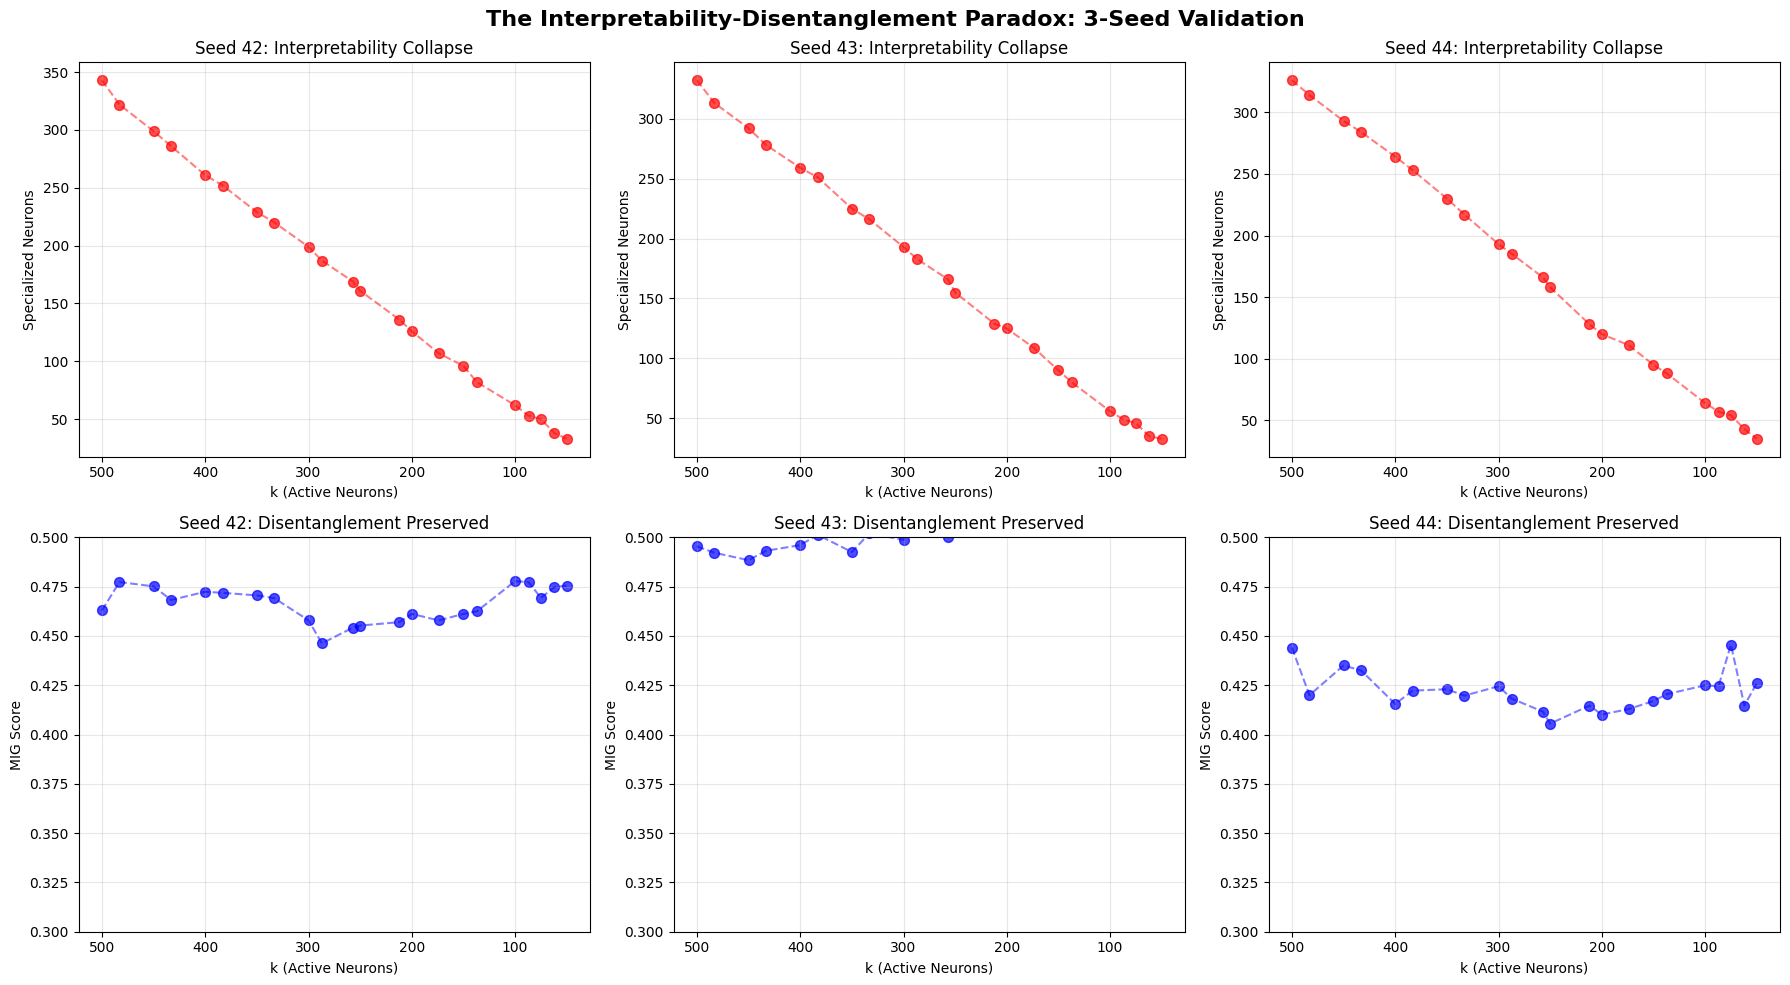

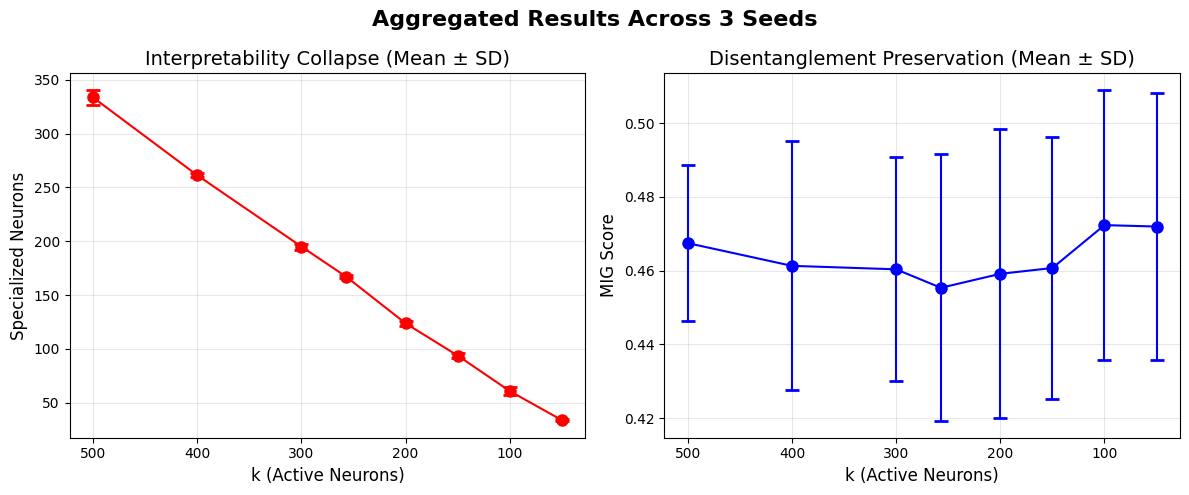


Summary Statistics Across 3 Seeds:
k=500: 333.7 ± 7.0 specialized neurons
k=50:  33.7 ± 0.9 specialized neurons
Collapse: 89.9%

MIG at k=500: 0.467 ± 0.021
MIG at k=50:  0.472 ± 0.036
MIG change: +1.0%


In [2]:
import pickle
import gzip
import matplotlib.pyplot as plt
import numpy as np

# Load results from all three seeds
seeds = [42, 43, 44]
all_results = []

for seed in seeds:
    filepath = f'./results/k500_50_seed{seed}_full_results.pkl'
    with gzip.open(filepath, 'rb') as f:
        results = pickle.load(f)
        all_results.append(results)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, (seed, results) in enumerate(zip(seeds, all_results)):
    metrics = results['metrics']
    k_values = [m['k_value'] for m in metrics]
    specialized = [m['specialized_high'] for m in metrics]
    mig_scores = [m['mig'] for m in metrics]
    dead_neurons = [m['dead_neurons'] for m in metrics]
    
    # Plot 1: Interpretability Collapse
    axes[0, idx].scatter(k_values, specialized, s=50, color='red', alpha=0.7)
    axes[0, idx].plot(sorted(k_values, reverse=True), 
                      [specialized[k_values.index(k)] for k in sorted(k_values, reverse=True)], 
                      'r--', alpha=0.5)
    axes[0, idx].set_xlabel('k (Active Neurons)')
    axes[0, idx].set_ylabel('Specialized Neurons')
    axes[0, idx].set_title(f'Seed {seed}: Interpretability Collapse')
    axes[0, idx].grid(True, alpha=0.3)
    axes[0, idx].invert_xaxis()
    
    # Plot 2: MIG Preservation  
    axes[1, idx].scatter(k_values, mig_scores, s=50, color='blue', alpha=0.7)
    axes[1, idx].plot(sorted(k_values, reverse=True),
                      [mig_scores[k_values.index(k)] for k in sorted(k_values, reverse=True)],
                      'b--', alpha=0.5)
    axes[1, idx].set_xlabel('k (Active Neurons)')
    axes[1, idx].set_ylabel('MIG Score')
    axes[1, idx].set_title(f'Seed {seed}: Disentanglement Preserved')
    axes[1, idx].grid(True, alpha=0.3)
    axes[1, idx].set_ylim([0.3, 0.5])
    axes[1, idx].invert_xaxis()

plt.suptitle('The Interpretability-Disentanglement Paradox: 3-Seed Validation', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('interpretability_paradox_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Create aggregate plot with error bars
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))

# Collect data at checkpoints
checkpoints = [500, 400, 300, 257, 200, 150, 100, 50]
mean_spec = []
std_spec = []
mean_mig = []
std_mig = []

for k in checkpoints:
    spec_at_k = []
    mig_at_k = []
    for results in all_results:
        metrics = results['metrics']
        for m in metrics:
            if abs(m['k_value'] - k) < 10:
                spec_at_k.append(m['specialized_high'])
                mig_at_k.append(m['mig'])
                break
    mean_spec.append(np.mean(spec_at_k))
    std_spec.append(np.std(spec_at_k))
    mean_mig.append(np.mean(mig_at_k))
    std_mig.append(np.std(mig_at_k))

# Plot with error bars
axes2[0].errorbar(checkpoints, mean_spec, yerr=std_spec, 
                  fmt='ro-', capsize=5, capthick=2, markersize=8)
axes2[0].set_xlabel('k (Active Neurons)', fontsize=12)
axes2[0].set_ylabel('Specialized Neurons', fontsize=12)
axes2[0].set_title('Interpretability Collapse (Mean ± SD)', fontsize=14)
axes2[0].grid(True, alpha=0.3)
axes2[0].invert_xaxis()

axes2[1].errorbar(checkpoints, mean_mig, yerr=std_mig,
                  fmt='bo-', capsize=5, capthick=2, markersize=8)
axes2[1].set_xlabel('k (Active Neurons)', fontsize=12)
axes2[1].set_ylabel('MIG Score', fontsize=12)
axes2[1].set_title('Disentanglement Preservation (Mean ± SD)', fontsize=14)
axes2[1].grid(True, alpha=0.3)
axes2[1].invert_xaxis()

plt.suptitle('Aggregated Results Across 3 Seeds', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('interpretability_paradox_aggregate.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary Statistics Across 3 Seeds:")
print("="*50)
print(f"k=500: {mean_spec[0]:.1f} ± {std_spec[0]:.1f} specialized neurons")
print(f"k=50:  {mean_spec[-1]:.1f} ± {std_spec[-1]:.1f} specialized neurons")
print(f"Collapse: {(1 - mean_spec[-1]/mean_spec[0])*100:.1f}%")
print(f"\nMIG at k=500: {mean_mig[0]:.3f} ± {std_mig[0]:.3f}")
print(f"MIG at k=50:  {mean_mig[-1]:.3f} ± {std_mig[-1]:.3f}")
print(f"MIG change: {((mean_mig[-1]/mean_mig[0]) - 1)*100:+.1f}%")